In [53]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct

# Step 0 
## Preparing main functions (based on matlab code) and importing images

In [54]:
I_orig = Image.open('2024_DF_Lab3_Code/lena_512.bmp')

I_orig = np.array(I_orig, dtype=float) # Convert the image to double precision

QF1 = 50
QF2 = 75

# Define the quantization matrix (Q50 as in the MATLAB code)
Q50 = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Adjust the quantization matrix based on QF
def quality_matrix_ajustment(QF: np.array) -> np.array:
    if QF > 50:
        QM = np.round(Q50 * ((100 - QF) / 50))
    elif QF < 50:
        QM = np.round(Q50 * (50 / QF))
    else:
        QM = Q50
    
    return QM.astype(float)

def zigzag(input_matrix: np.array) -> np.array:
    # Initialize the result list for storing the zigzag pattern
    rows, cols = input_matrix.shape
    result = []
    
    # Directions for zigzagging
    directions = [(-1, 1), (1, -1)]  # (up-right), (down-left)
    current_direction = 0
    row, col = 0, 0
    
    # Traverse the matrix
    for _ in range(rows * cols):
        result.append(input_matrix[row, col])
        
        # Determine the next step
        new_row = row + directions[current_direction][0]
        new_col = col + directions[current_direction][1]
        
        # Change direction or handle boundaries
        if new_row >= rows:  # Hit the bottom, move right
            new_row = row
            new_col = col + 1
            current_direction = 1 - current_direction
        elif new_col >= cols:  # Hit the right, move down
            new_row = row + 1
            new_col = col
            current_direction = 1 - current_direction
        elif new_row < 0:  # Hit the top, move right
            new_row = 0
            current_direction = 1 - current_direction
        elif new_col < 0:  # Hit the left, move down
            new_col = 0
            current_direction = 1 - current_direction

        row, col = new_row, new_col

    return np.array(result)


# Define the function for applying DCT and quantization
def jpeg_encoding(image: np.array, QM: np.array) -> tuple[np.array]:
    image = image - 128 # Center pixel values around 0
    row, coln = image.shape
    
    dct_domain = np.zeros_like(image) # DCT transformed image
    dct_quantized = np.zeros_like(image) # DCT quantized coeff
    dct_quantized_coeff = np.zeros((64, len(range(0, row, 8)) * len(range(0, coln, 8)))) # Store zigzag ordered quantized coeff low-frequency components (which are clustered in the top-left corner) are grouped together at the start of the array, followed by the high-frequency components (which tend to be zeros after quantization)

    # Process 8x8 blocks
    k = 0
    for i1 in range(0, row, 8):
        for i2 in range(0, coln, 8):
            z_block = image[i1:i1+8, i2:i2+8]
            
            # Apply DCT
            win1 = dct(dct(z_block,axis=0,norm='ortho'),axis=1,norm='ortho')
            dct_domain[i1:i1+8,i2:i2+8] = win1
            
            # Quantize the DCT coefficients
            win2 = np.round(win1 / QM)
            dct_quantized[i1:i1+8, i2:i2+8] = win2
            dct_quantized_coeff[:, k-1] = zigzag(win2)
            k += 1
    
    return dct_domain, dct_quantized, dct_quantized_coeff

def jpeg_decoding(dct_quantized: np.array, QM: np.array) -> tuple[np.array, np.array]:
    row, coln = dct_quantized.shape

    dct_dequantized = np.zeros_like(dct_quantized)
    dct_restored = np.zeros_like(dct_quantized)

    for i1 in range(0, row, 8):
        for i2 in range(0, coln, 8):
            win2 = dct_quantized[i1:i1+8,i2:i2+8]
            
            win3 = win2 * QM
            dct_dequantized[i1:i1+8,i2:i2+8] = win3

            win4 = cv2.idct(win3)
            dct_restored[i1:i1+8,i2:i2+8]=win4

    return dct_dequantized, dct_restored

def JPEG_compression(I, QF):
    QM = quality_matrix_ajustment(QF)
    dct_domain, dct_quantized, dct_quantized_coeff = jpeg_encoding(I, QM)
    dct_dequantized, dct_restored = jpeg_decoding(dct_quantized, QM)

    return dct_domain, dct_quantized, dct_quantized_coeff, dct_dequantized, dct_restored+128

# Step 1 generation of JPEG compressed and double JPEG compressed images

## Investigate properties of quantization matrix (QM) for different values of quality factor (QF)

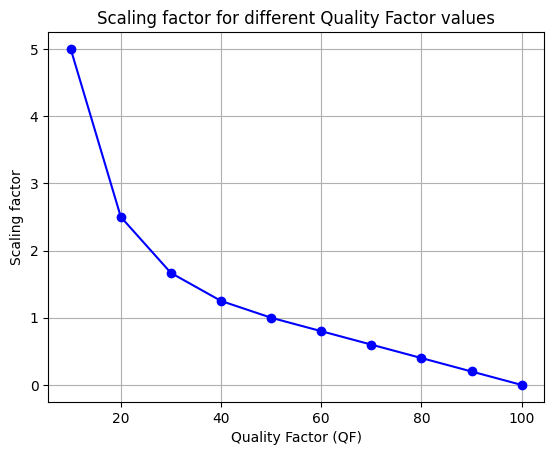

In [55]:
qf_values = []
factor_values = []

for qf in range(10, 110, 10):
    qf_values.append(qf)
    if qf > 50:
        factor = (100 - qf) / 50
    else:
        factor = 50 / qf

    factor_values.append(factor)

# Create the plot
plt.plot(qf_values, factor_values, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Quality Factor (QF)')
plt.ylabel('Scaling factor')
plt.title('Scaling factor for different Quality Factor values')

# Display the plot
plt.grid(True)
plt.show()

The quality factor (QF) determines the level of compression by scaling the QM—higher QF values result in less aggressive compression, preserving more image detail, while lower QF values increase compression at the cost of visual quality. As we can observe the graphic above, scaling factor is near 0 when the QF is near 100, which means (as expected) that the compression is low. More we decrease the quality factor, more is the scaling factor, so the compression will be more agressive.

## Generate JPEG compressed image with QF1

[[163.98773956 163.69738872 163.16089034 ... 178.67169936 160.43176609
  131.09809542]
 [163.67099319 163.38064236 162.84414397 ... 171.75275944 153.80342172
  126.36584675]
 [163.08572222 162.79537139 162.25887301 ... 170.74965082 153.6410422
  129.33372861]
 ...
 [ 41.05727445  43.35668742  46.73442872 ...  99.3383809   97.76012894
   96.26265762]
 [ 41.52435704  44.34637485  48.463191   ... 101.39432536 101.70249635
  101.61470267]
 [ 43.26539298  46.37024249  50.88704306 ... 103.48660495 105.20445358
  106.15446177]]


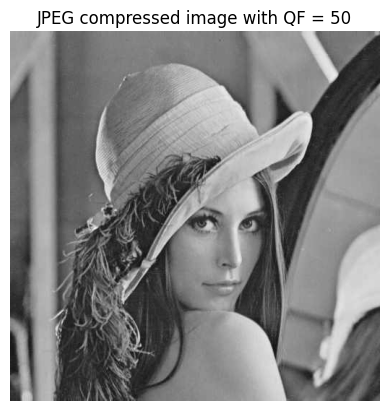

In [56]:
compressed_image = JPEG_compression(I_orig, QF1)
print(compressed_image[4])
plt.imshow(compressed_image[4], cmap='gray')
plt.title('JPEG compressed image with QF = 50')
plt.axis('off')
plt.show()

## Generate double JPEG compressed image with QF2 (QF2 ≠ QF1)

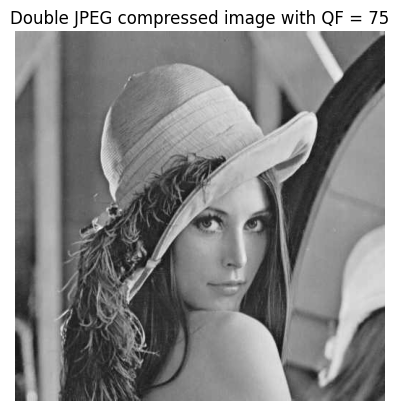

In [57]:
double_compressed_image = JPEG_compression(compressed_image[4], QF2)
plt.imshow(double_compressed_image[4], cmap='gray')
plt.title('Double JPEG compressed image with QF = 75')
plt.axis('off')
plt.show()

# Step 2 analysis of DCT coefficients of JPEG compressed images

## Global analysis of DCT coefficients:

In [58]:
def plot_histogram_coefficient(dct_quantized_coeff, dct_quantized_coeff2, bins):
    # Calculate histograms for both DCT matrices
    y_quantized, _ = np.histogram(dct_quantized_coeff.flatten(), bins=bins)
    y_quantized2, _ = np.histogram(dct_quantized_coeff2.flatten(), bins=bins)

    # Plot the histograms
    plt.figure(figsize=(30, 10))

    # Plot the first histogram (One time compressed)
    plt.subplot(2, 1, 1)
    plt.bar(bins[:-1], y_quantized, width=0.8, color='b', alpha=0.7)
    plt.title('One time compressed')
    plt.yscale('log')

    # Plot the second histogram (Double compressed)
    plt.subplot(2, 1, 2)
    plt.bar(bins[:-1], y_quantized2, width=0.8, color='r', alpha=0.7)
    plt.title('Double compressed')
    plt.yscale('log')

    plt.suptitle(f'Global histogram of DCT coeff\nQF1 = {QF1}; QF2 = {QF2}')

    # Display the plots
    plt.tight_layout(rect=[0, 0, 1, 0.96])

In [59]:
compressed_image_qf1 = JPEG_compression(I_orig, QF1)
double_compressed_image_qf2 = JPEG_compression(compressed_image_qf1[4], QF2)

compressed_image_qf2 = JPEG_compression(I_orig, QF2)
double_compressed_image_qf1 = JPEG_compression(compressed_image_qf2[4], QF1)

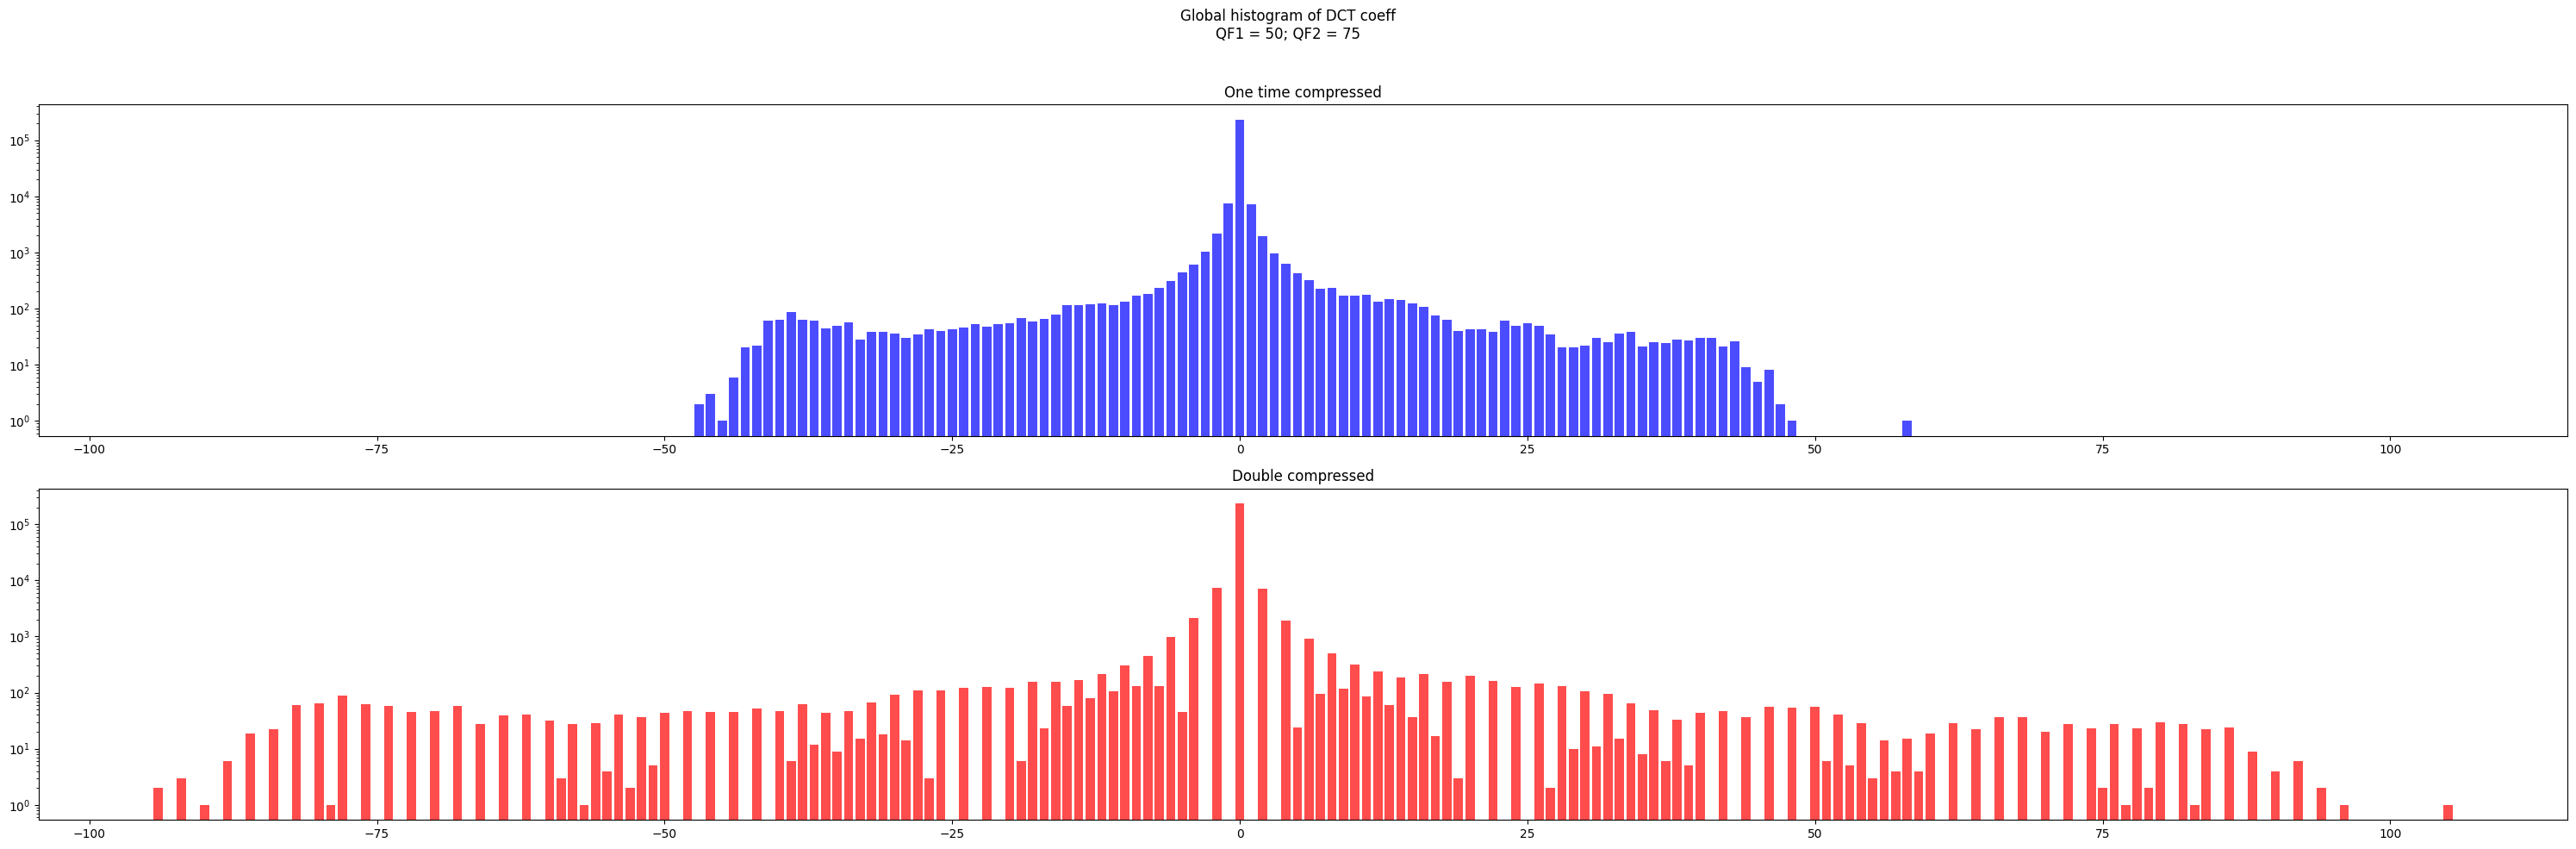

In [60]:
# Find the minimum and maximum DCT coefficients for both sets
min_dct = min(compressed_image_qf1[2].flatten().min(), double_compressed_image_qf2[2].flatten().min())
max_dct = max(compressed_image_qf1[2].flatten().max(), double_compressed_image_qf2[2].flatten().max())

# Define the bin range for the histogram
x_bin = np.arange(min_dct, max_dct + 1)

plot_histogram_coefficient(compressed_image_qf1[2], double_compressed_image_qf2[2], x_bin)

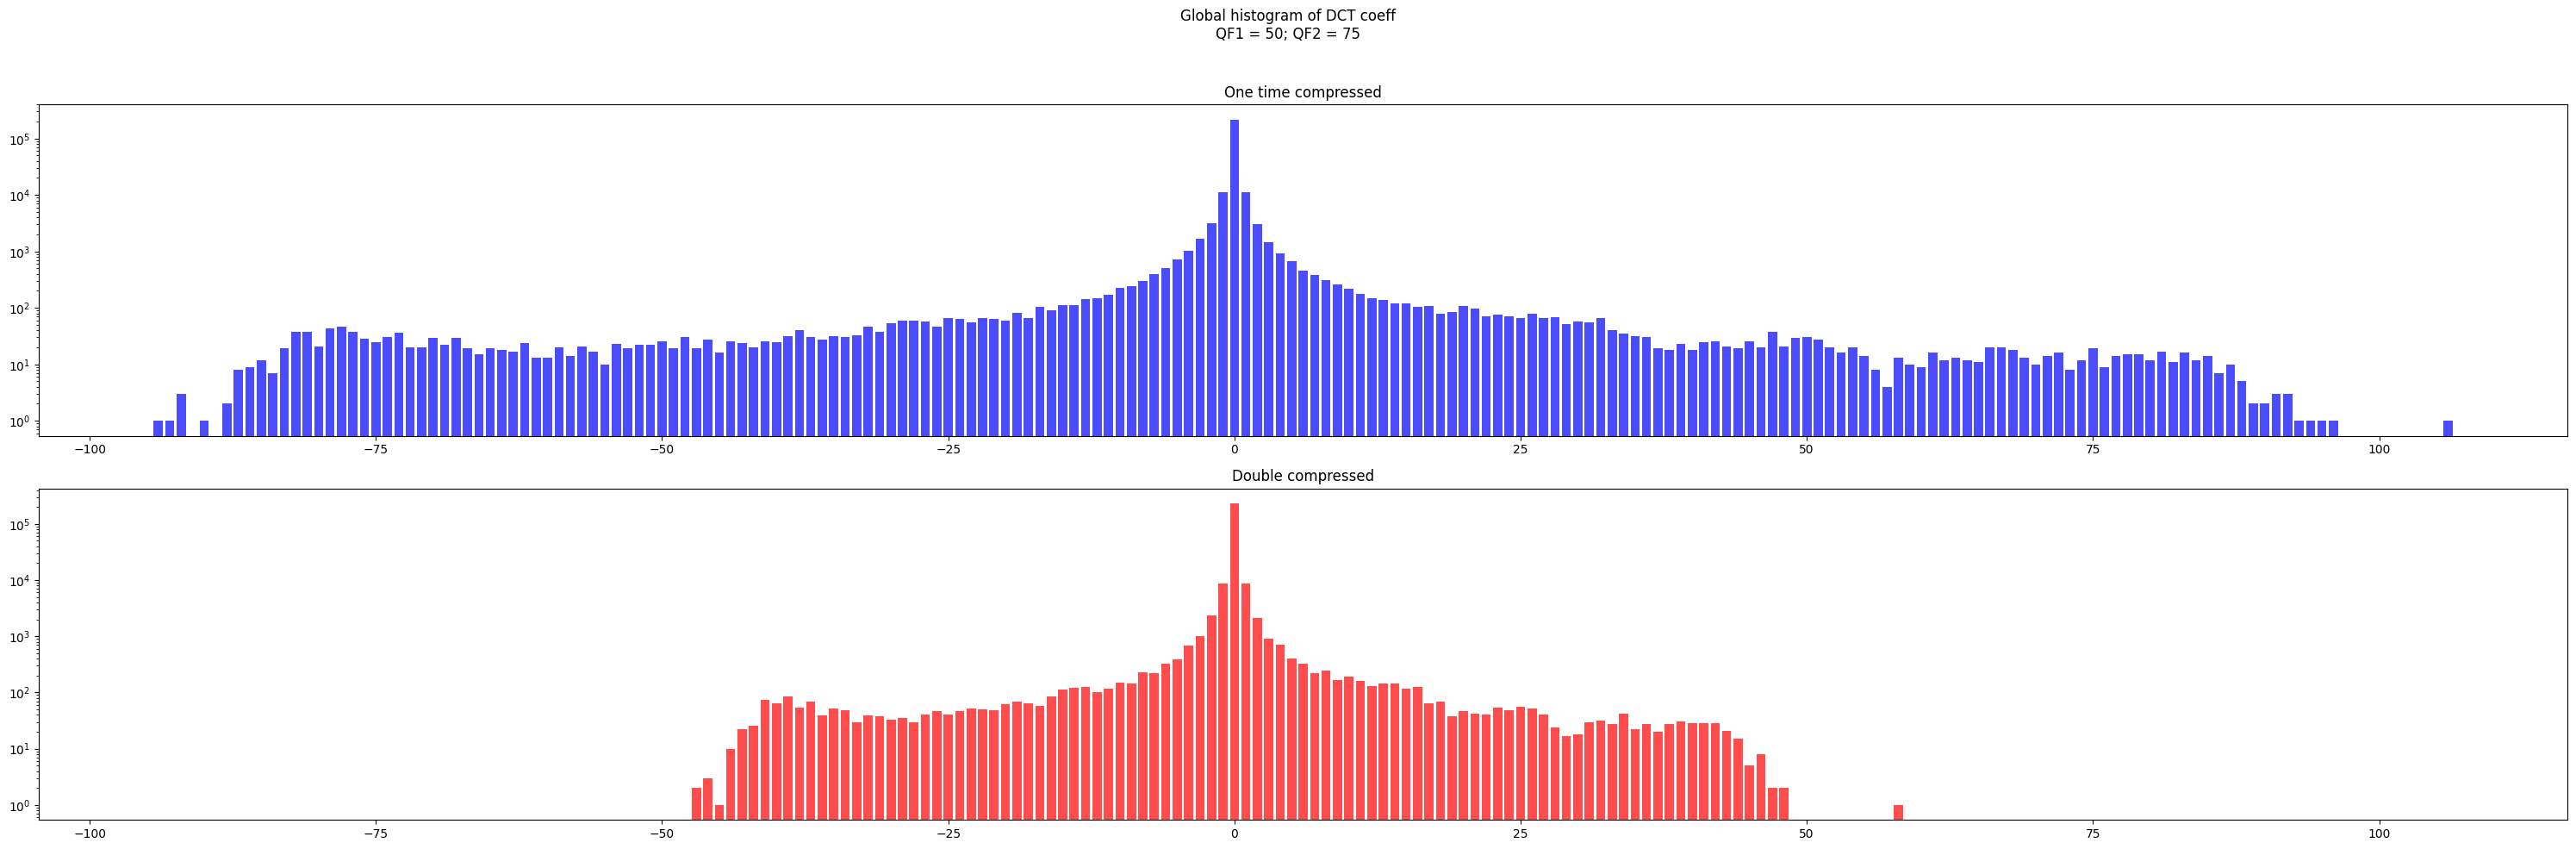

In [61]:
# Find the minimum and maximum DCT coefficients for both sets
min_dct = min(compressed_image_qf2[2].flatten().min(), double_compressed_image_qf1[2].flatten().min())
max_dct = max(compressed_image_qf2[2].flatten().max(), double_compressed_image_qf1[2].flatten().max())

# Define the bin range for the histogram
x_bin = np.arange(min_dct, max_dct + 1)

plot_histogram_coefficient(compressed_image_qf2[2], double_compressed_image_qf1[2], x_bin)

In both histograms we can see that a lot of values are concentrated near 0. This is an expected behaviour, because as we know DCT quantization tends to reduce high frequency values to 0 and keep all important information if low frequency values. 

We can observe that QF1 has a more aggressive compression compare to QF2. The values are less dispersed. So higher is QF, more details and larger is the bin repartition.

## Pairwise analysis of DCT coefficients

In [62]:
def plot_histogram_coefficient_pairwise(dct_quantized_coeff, dct_quantized_coeff2):
    for i in range(10):

        min_dct = min(dct_quantized_coeff[i, :].min(), dct_quantized_coeff2[i, :].min())
        max_dct = max(dct_quantized_coeff[i, :].max(), dct_quantized_coeff2[i, :].max())
        x_bin = np.arange(min_dct, max_dct + 1)

        y_quantized, _ = np.histogram(dct_quantized_coeff[i, :], bins=x_bin)
        y_quantized2, _ = np.histogram(dct_quantized_coeff2[i, :], bins=x_bin)

        # Plot the histograms
        plt.figure(figsize=(30, 10))

        # Plot the first histogram (One time compressed)
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot on the left
        plt.bar(x_bin[:-1], y_quantized, width=0.8, color='b', alpha=0.7)
        plt.title('One time compressed')

        # Plot the second histogram (Double compressed)
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot on the right
        plt.bar(x_bin[:-1], y_quantized2, width=0.8, color='r', alpha=0.7)
        plt.title('Double compressed')

        # Add a super title (equivalent to MATLAB's suptitle)
        plt.suptitle(f'Global histogram of DCT coeff\nQF1 = {QF1}; QF2 = {QF2}')

        # Display the plots
        plt.tight_layout(rect=[0, 0, 1, 0.96])

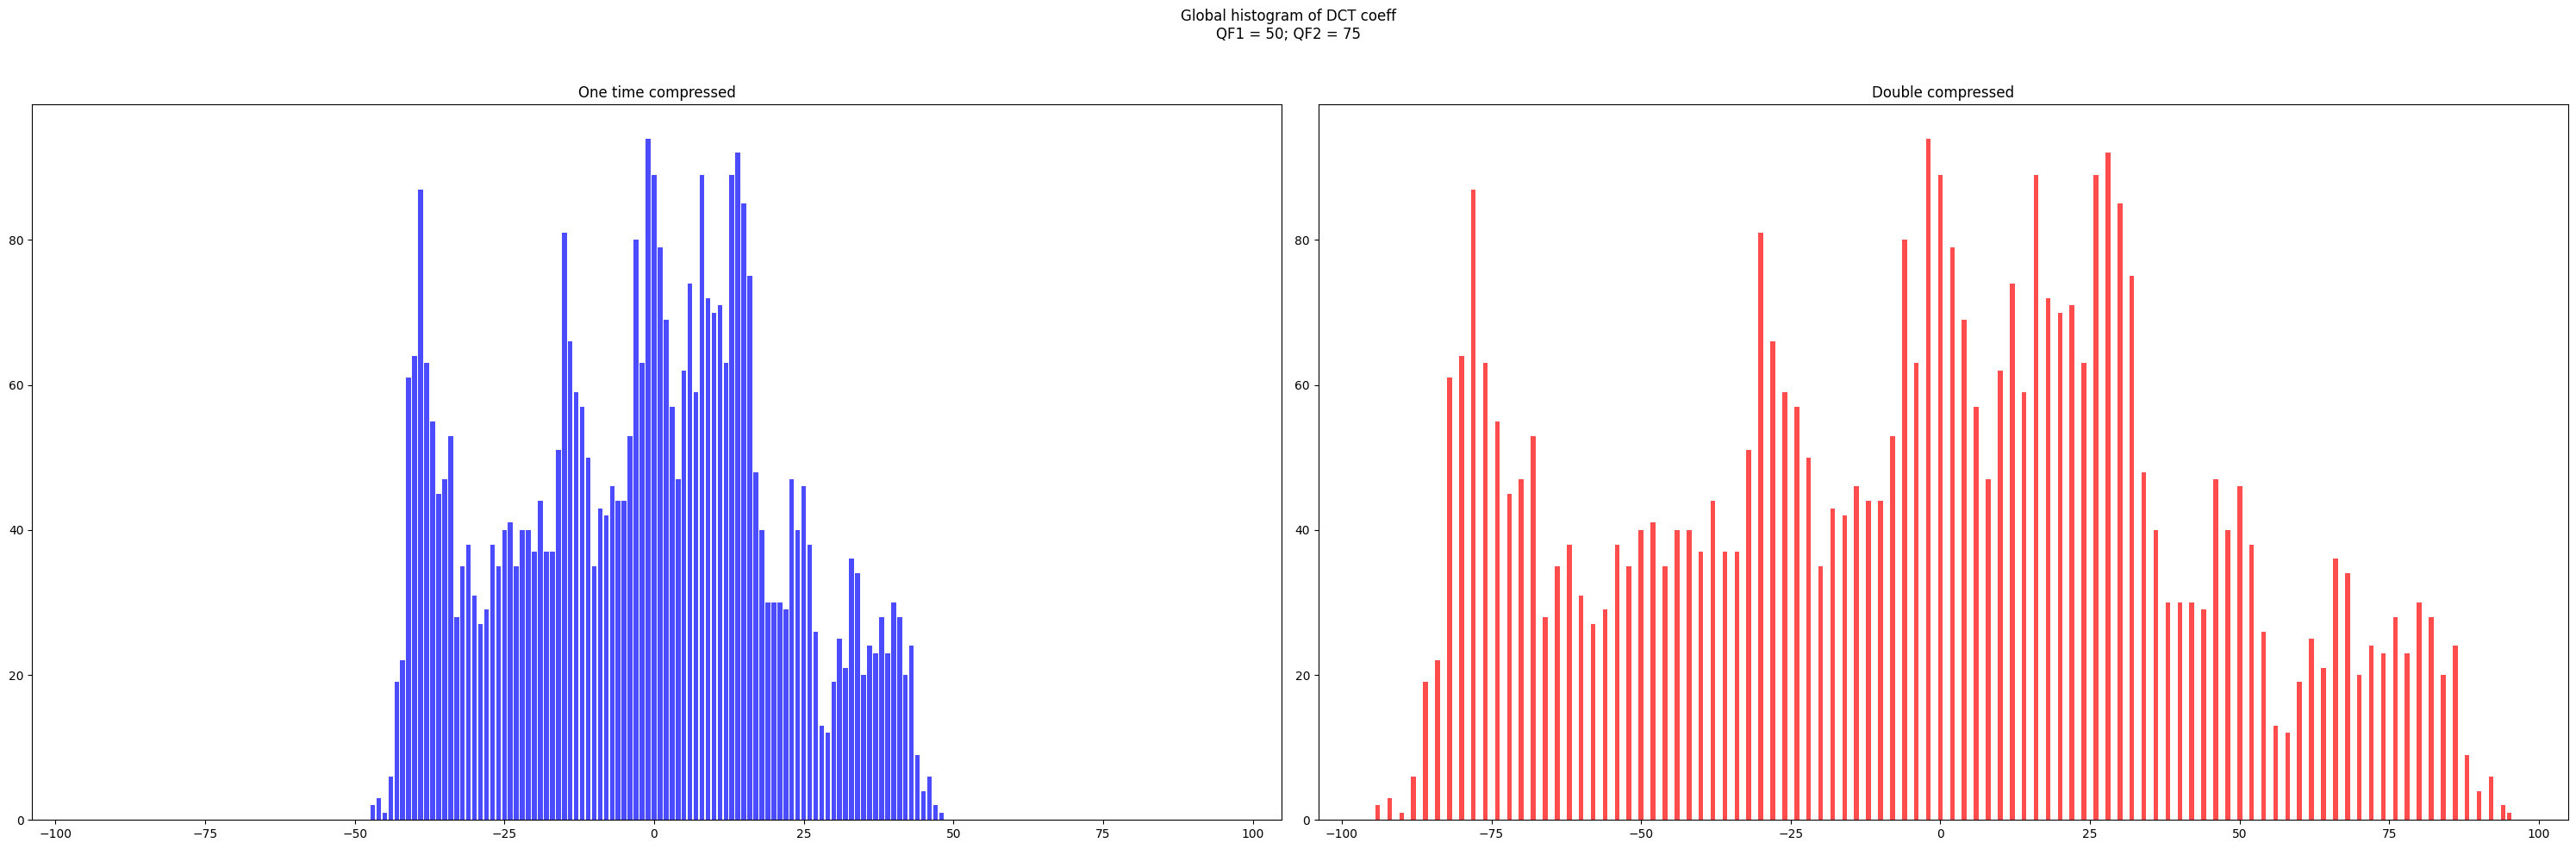

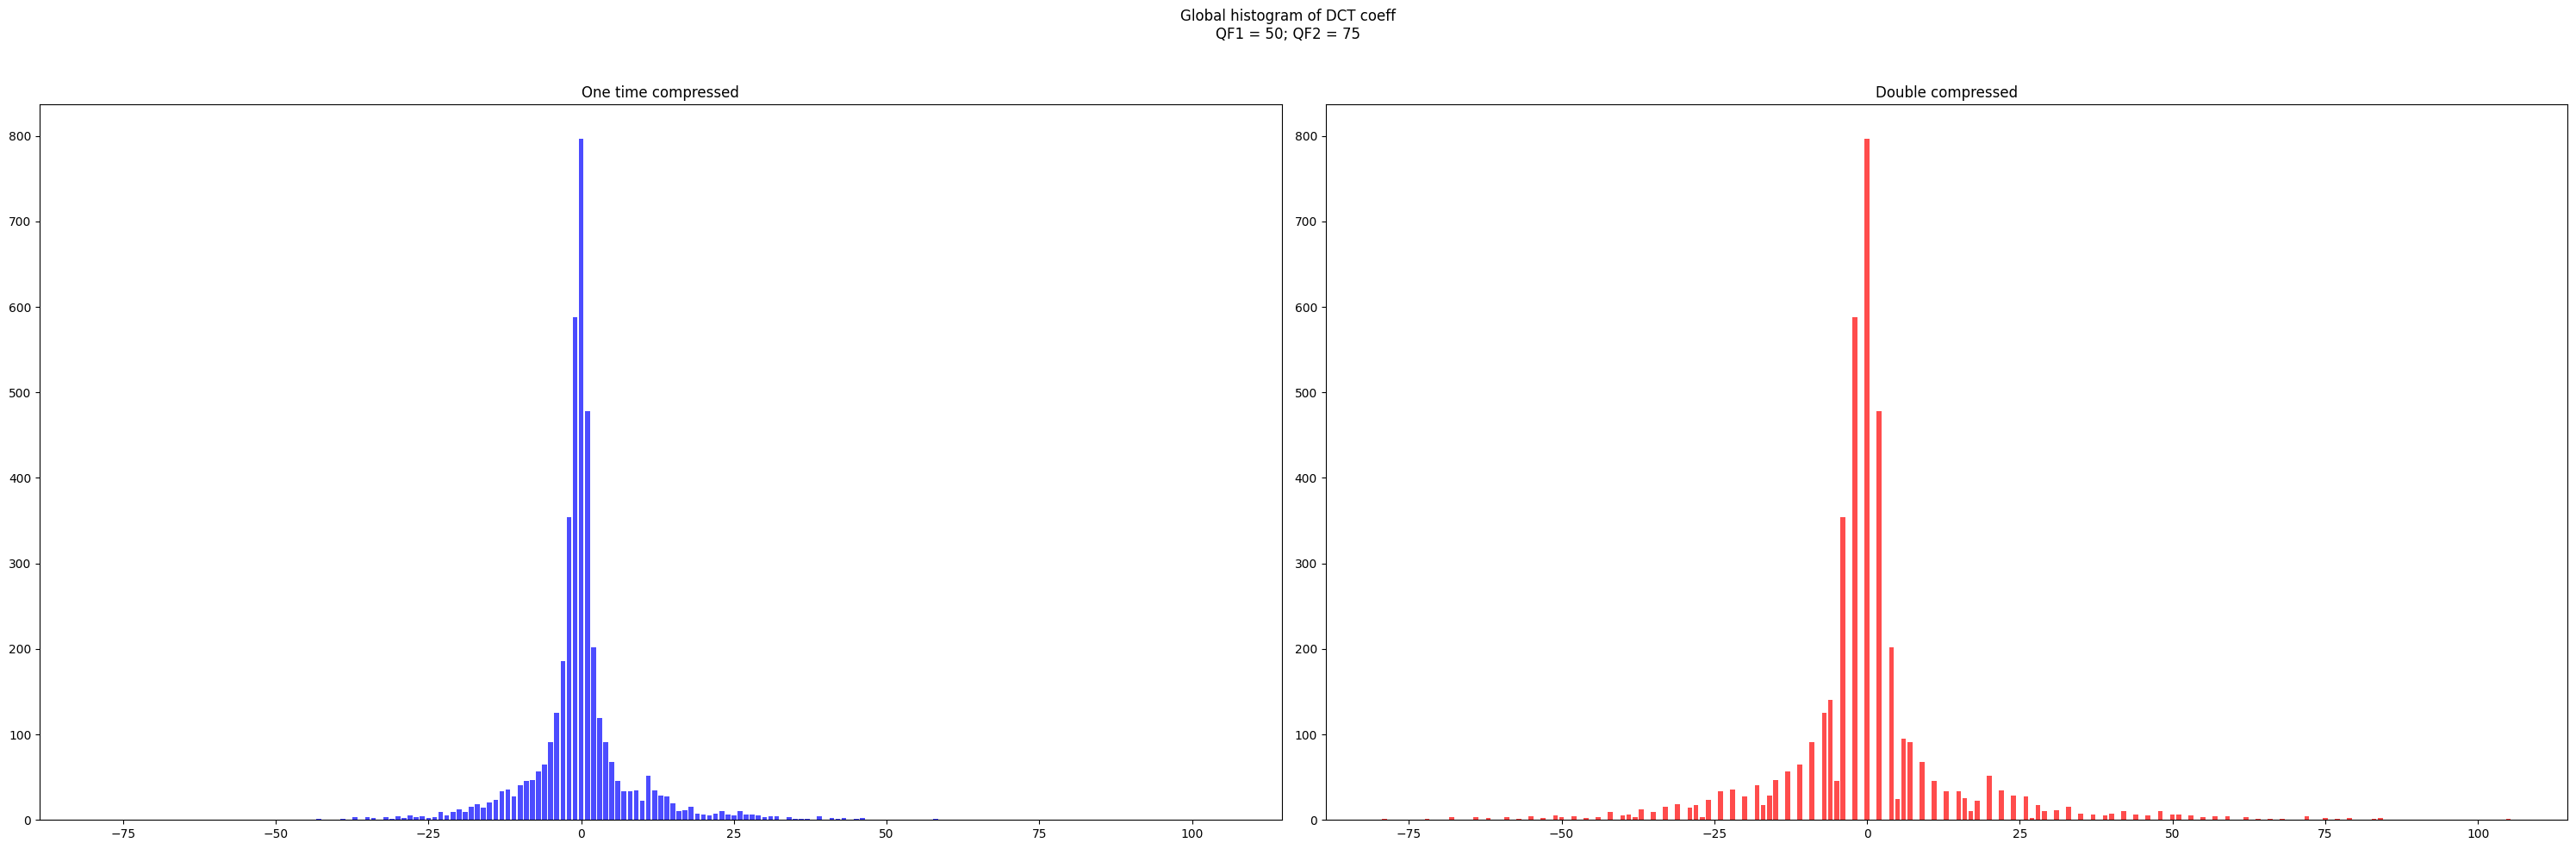

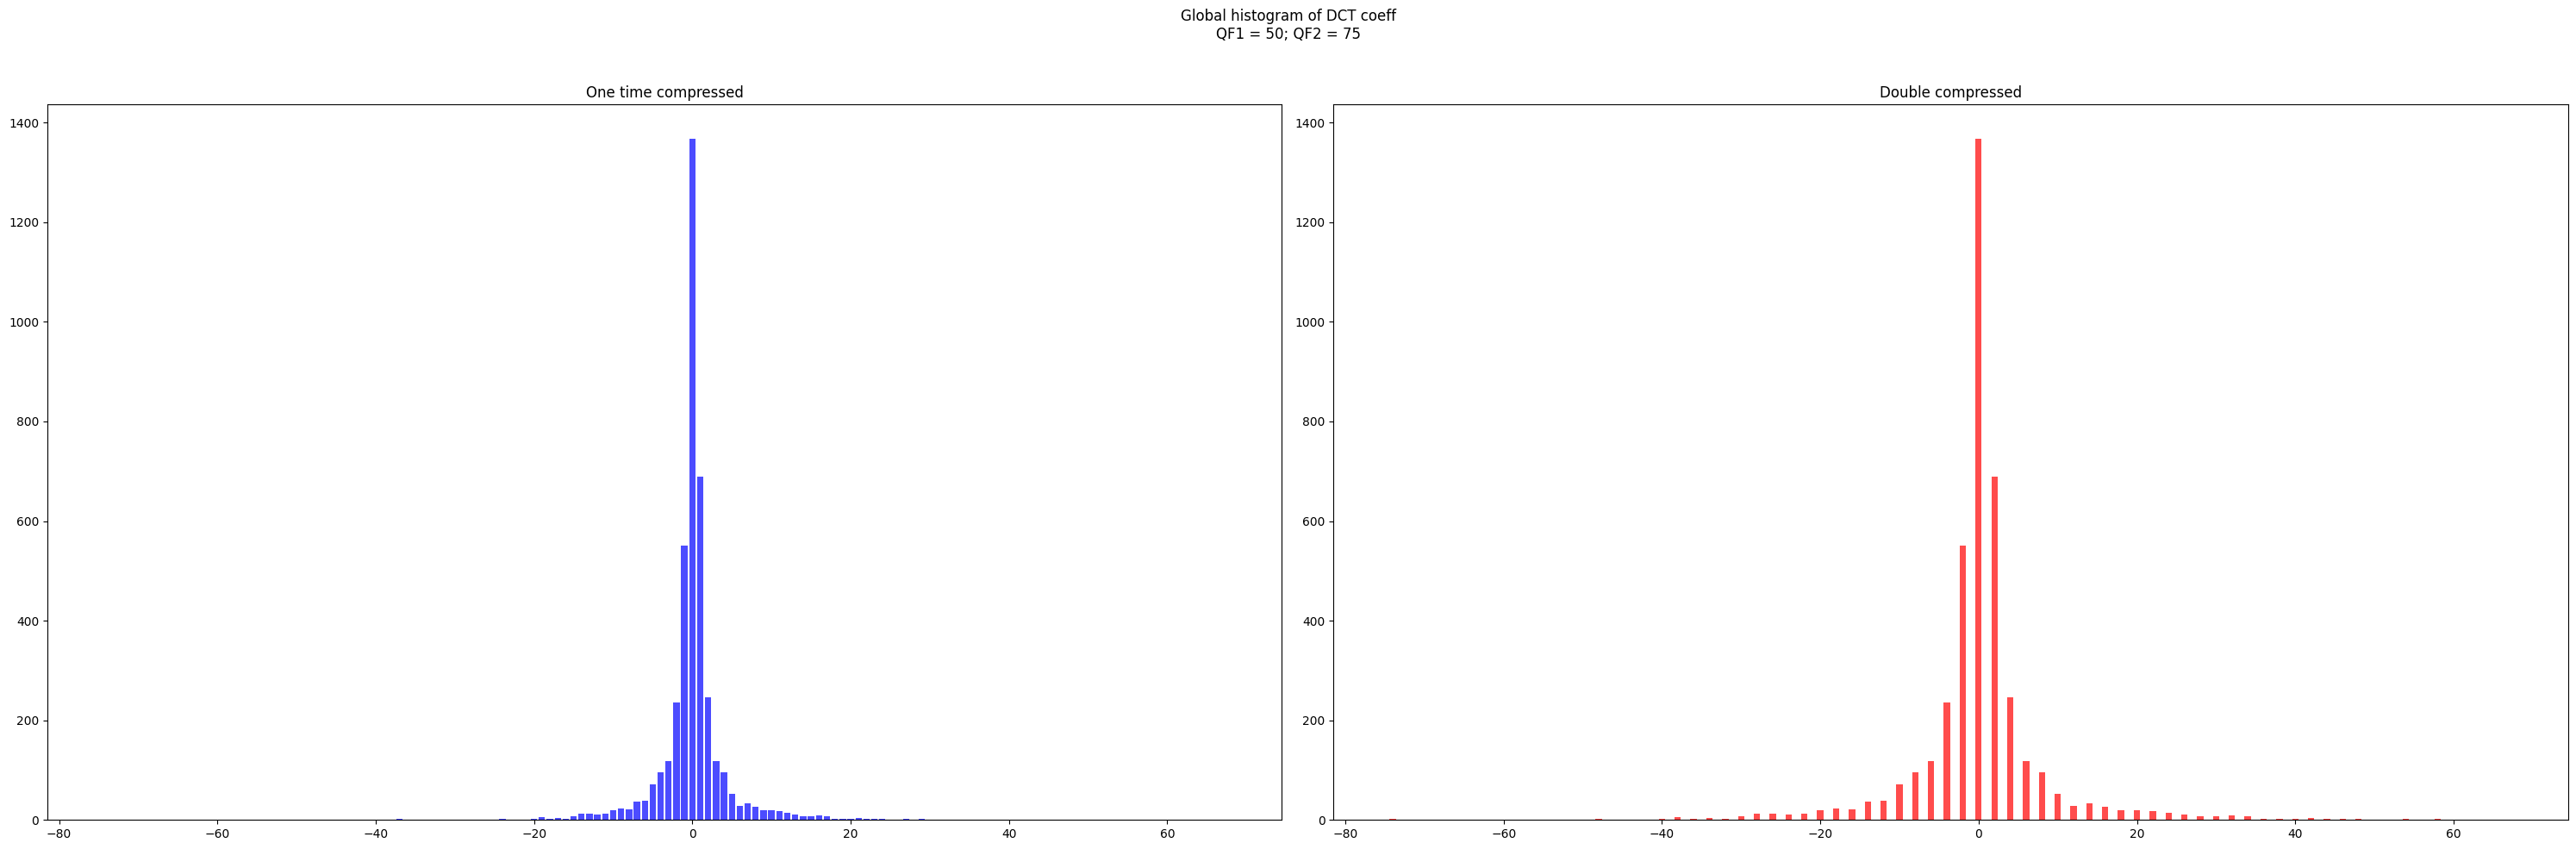

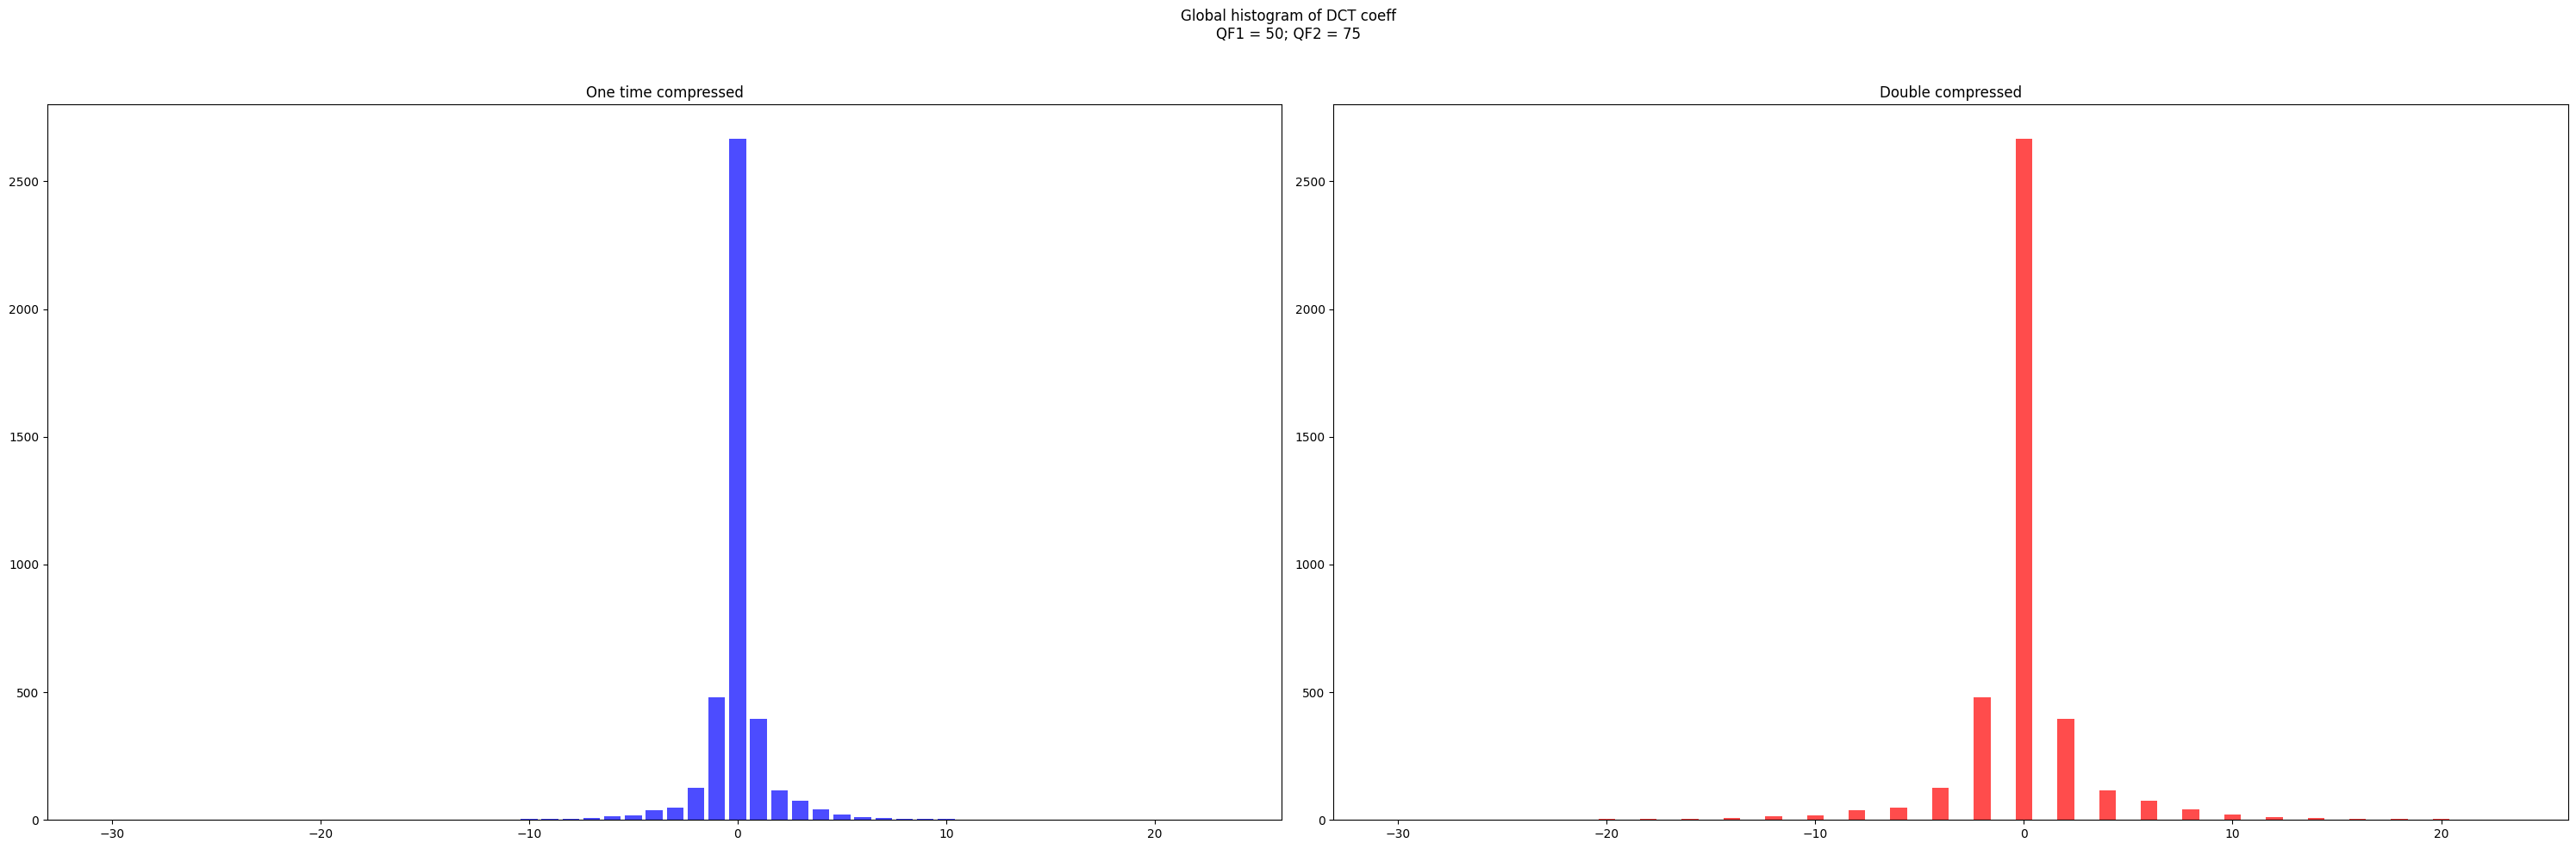

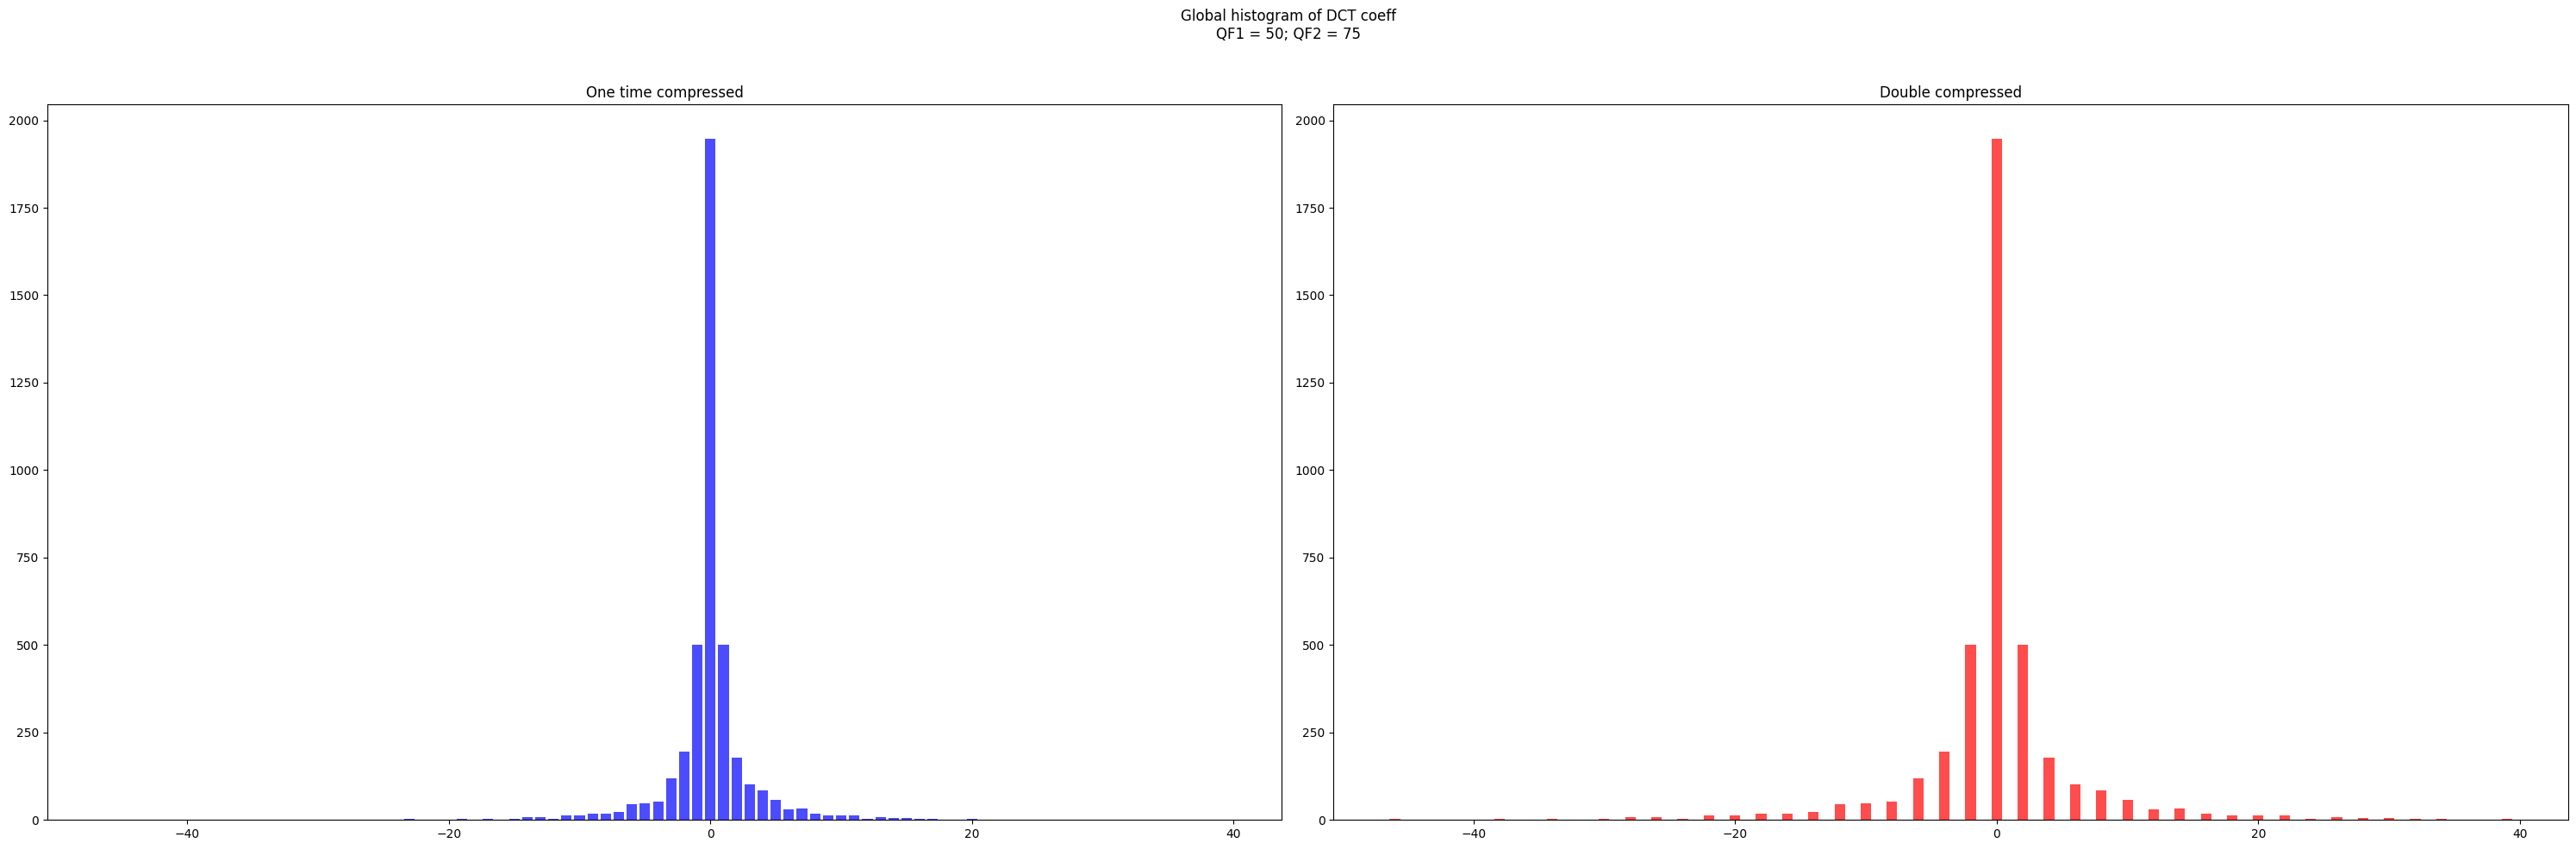

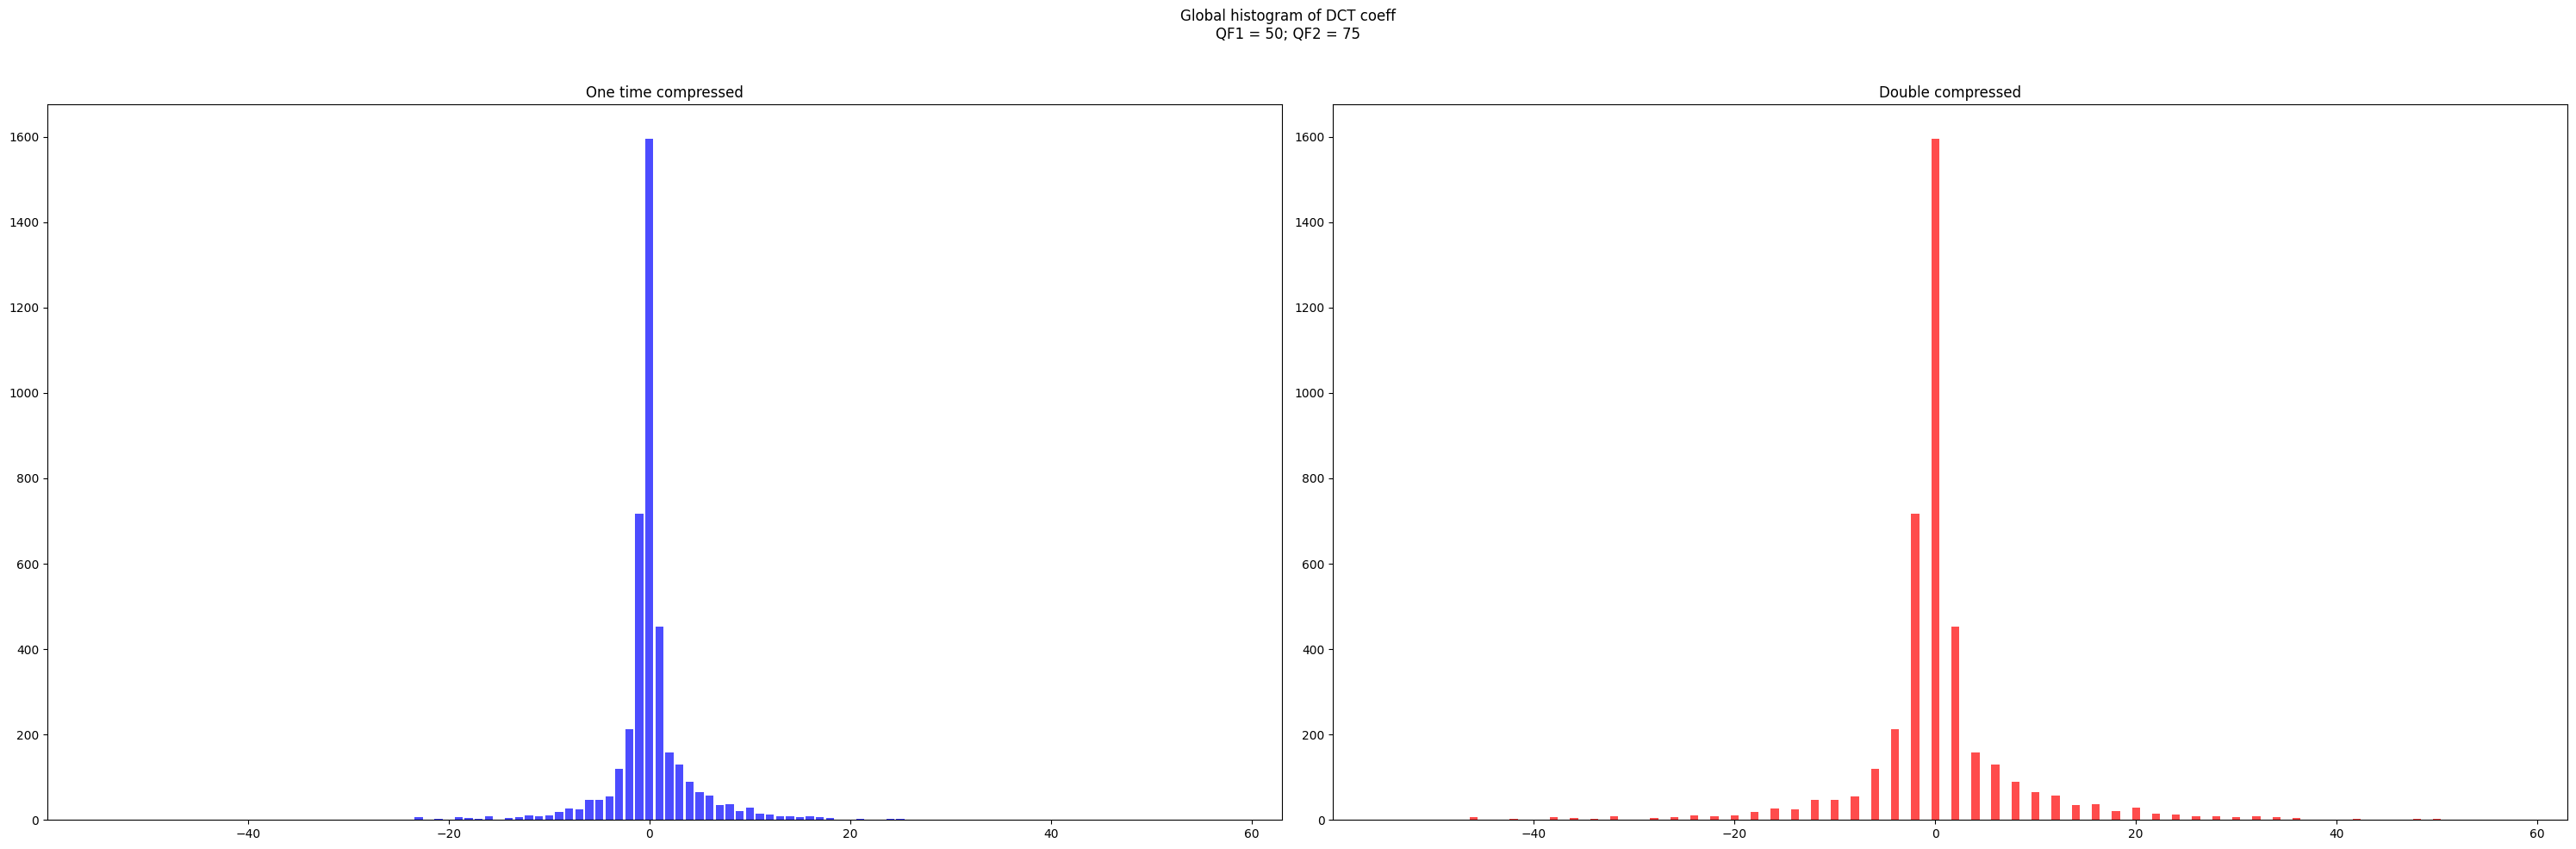

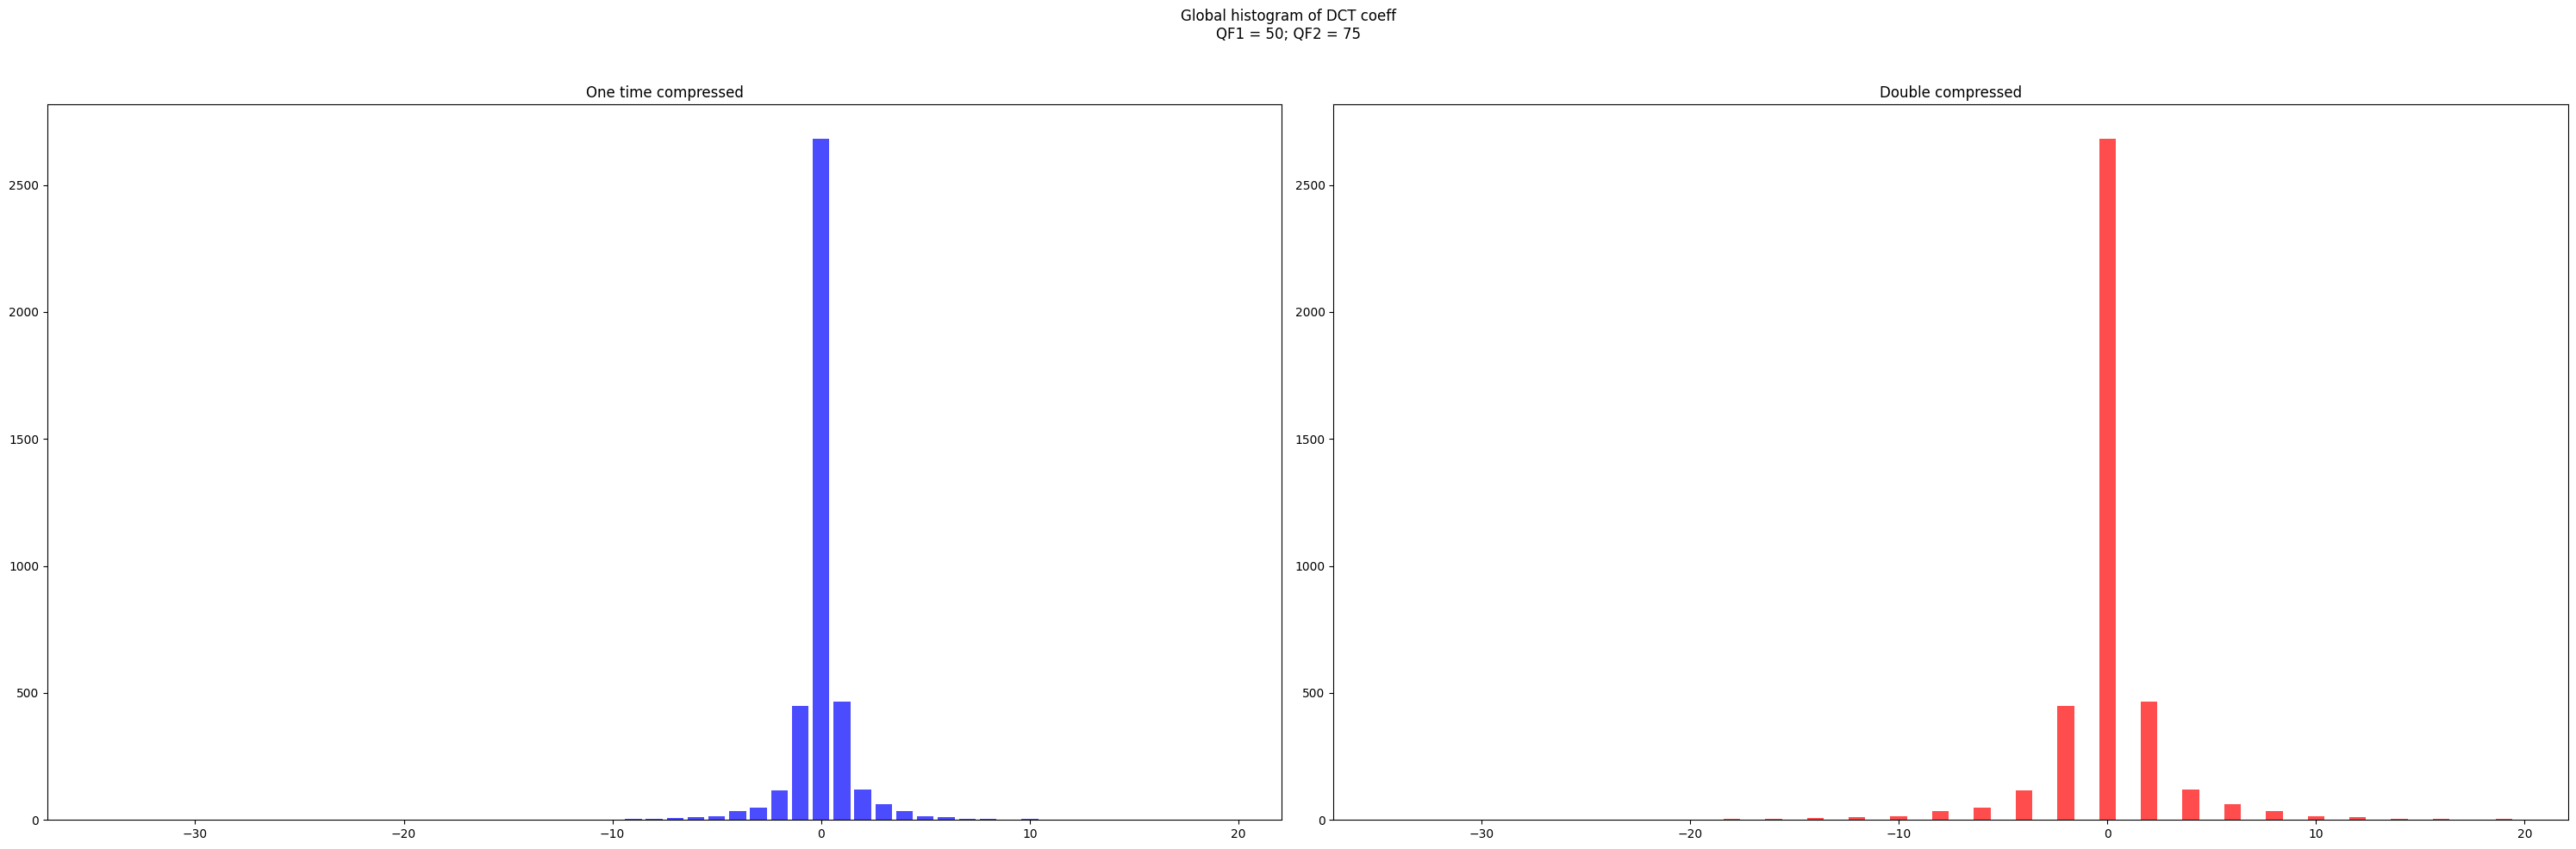

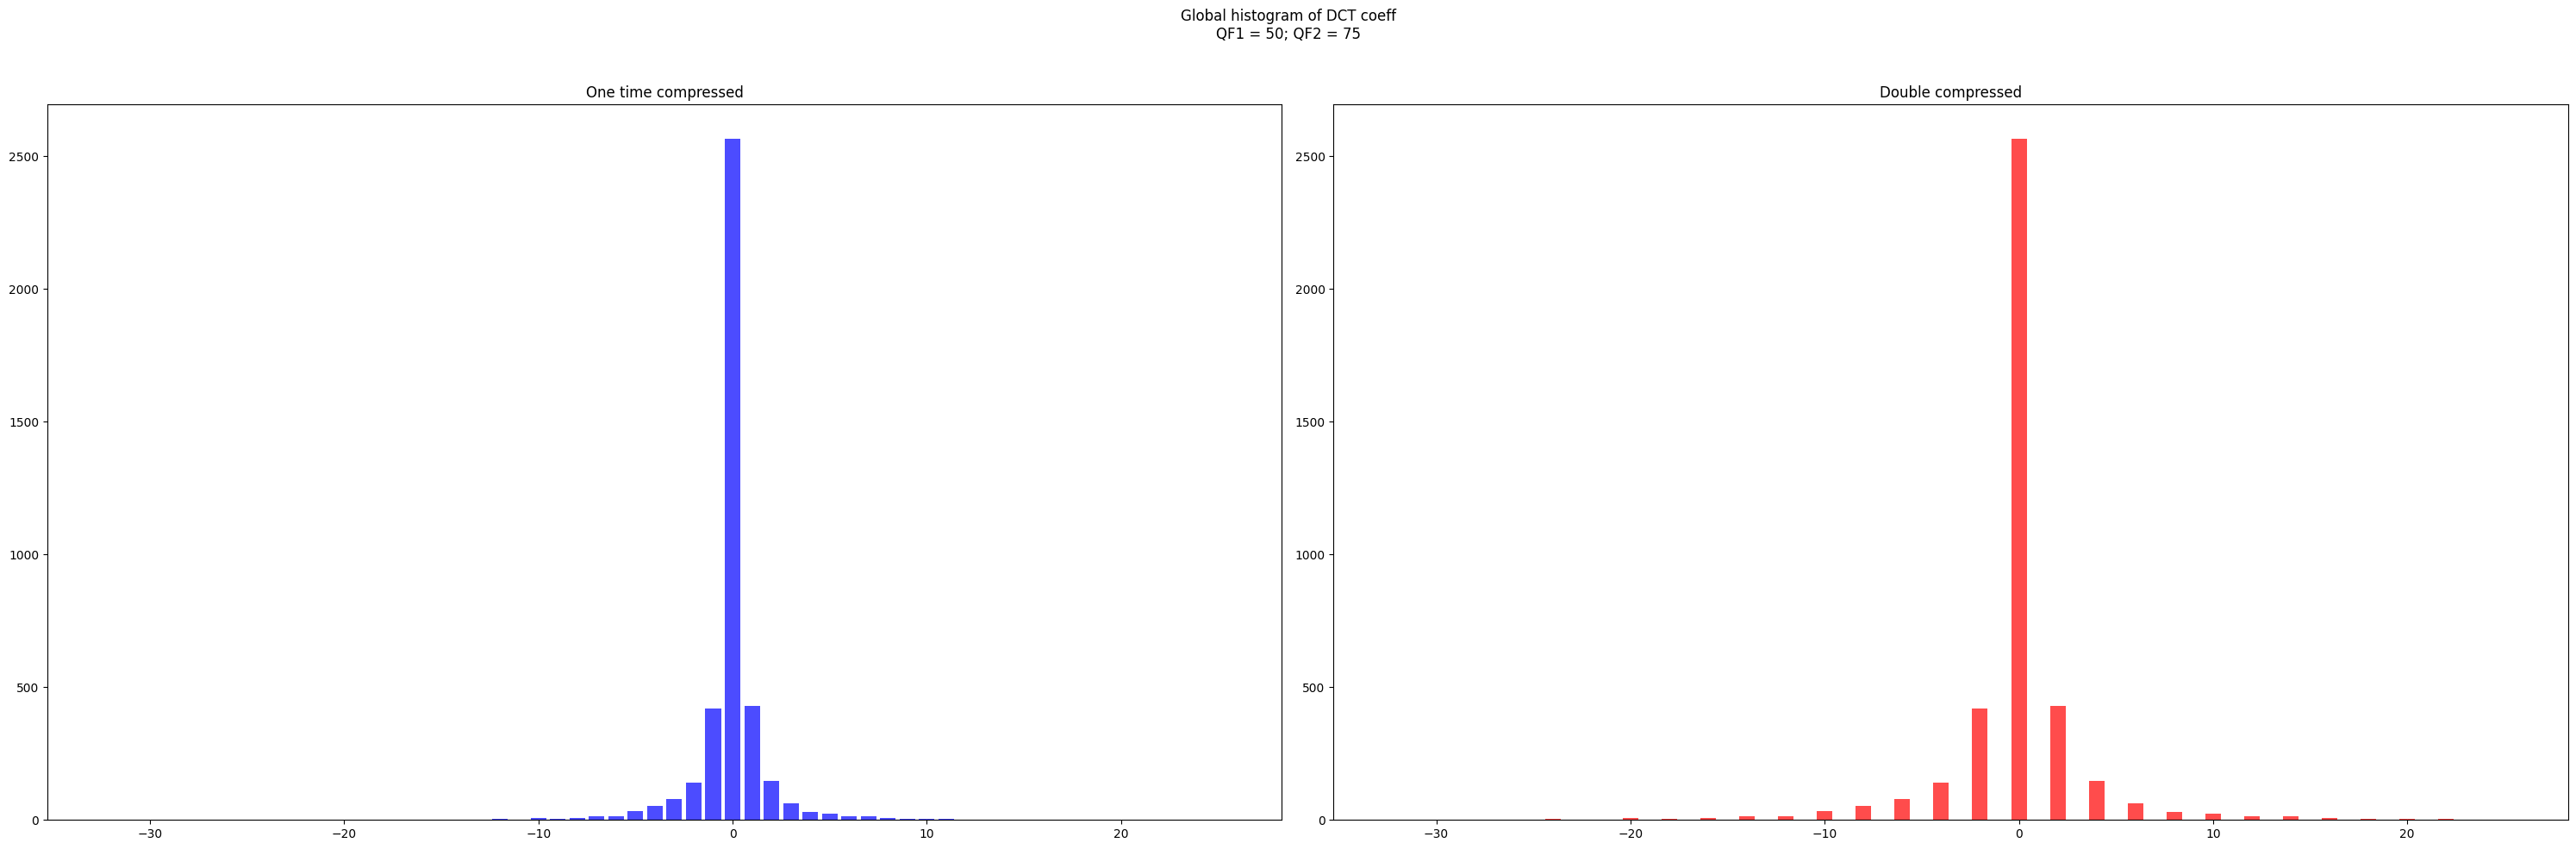

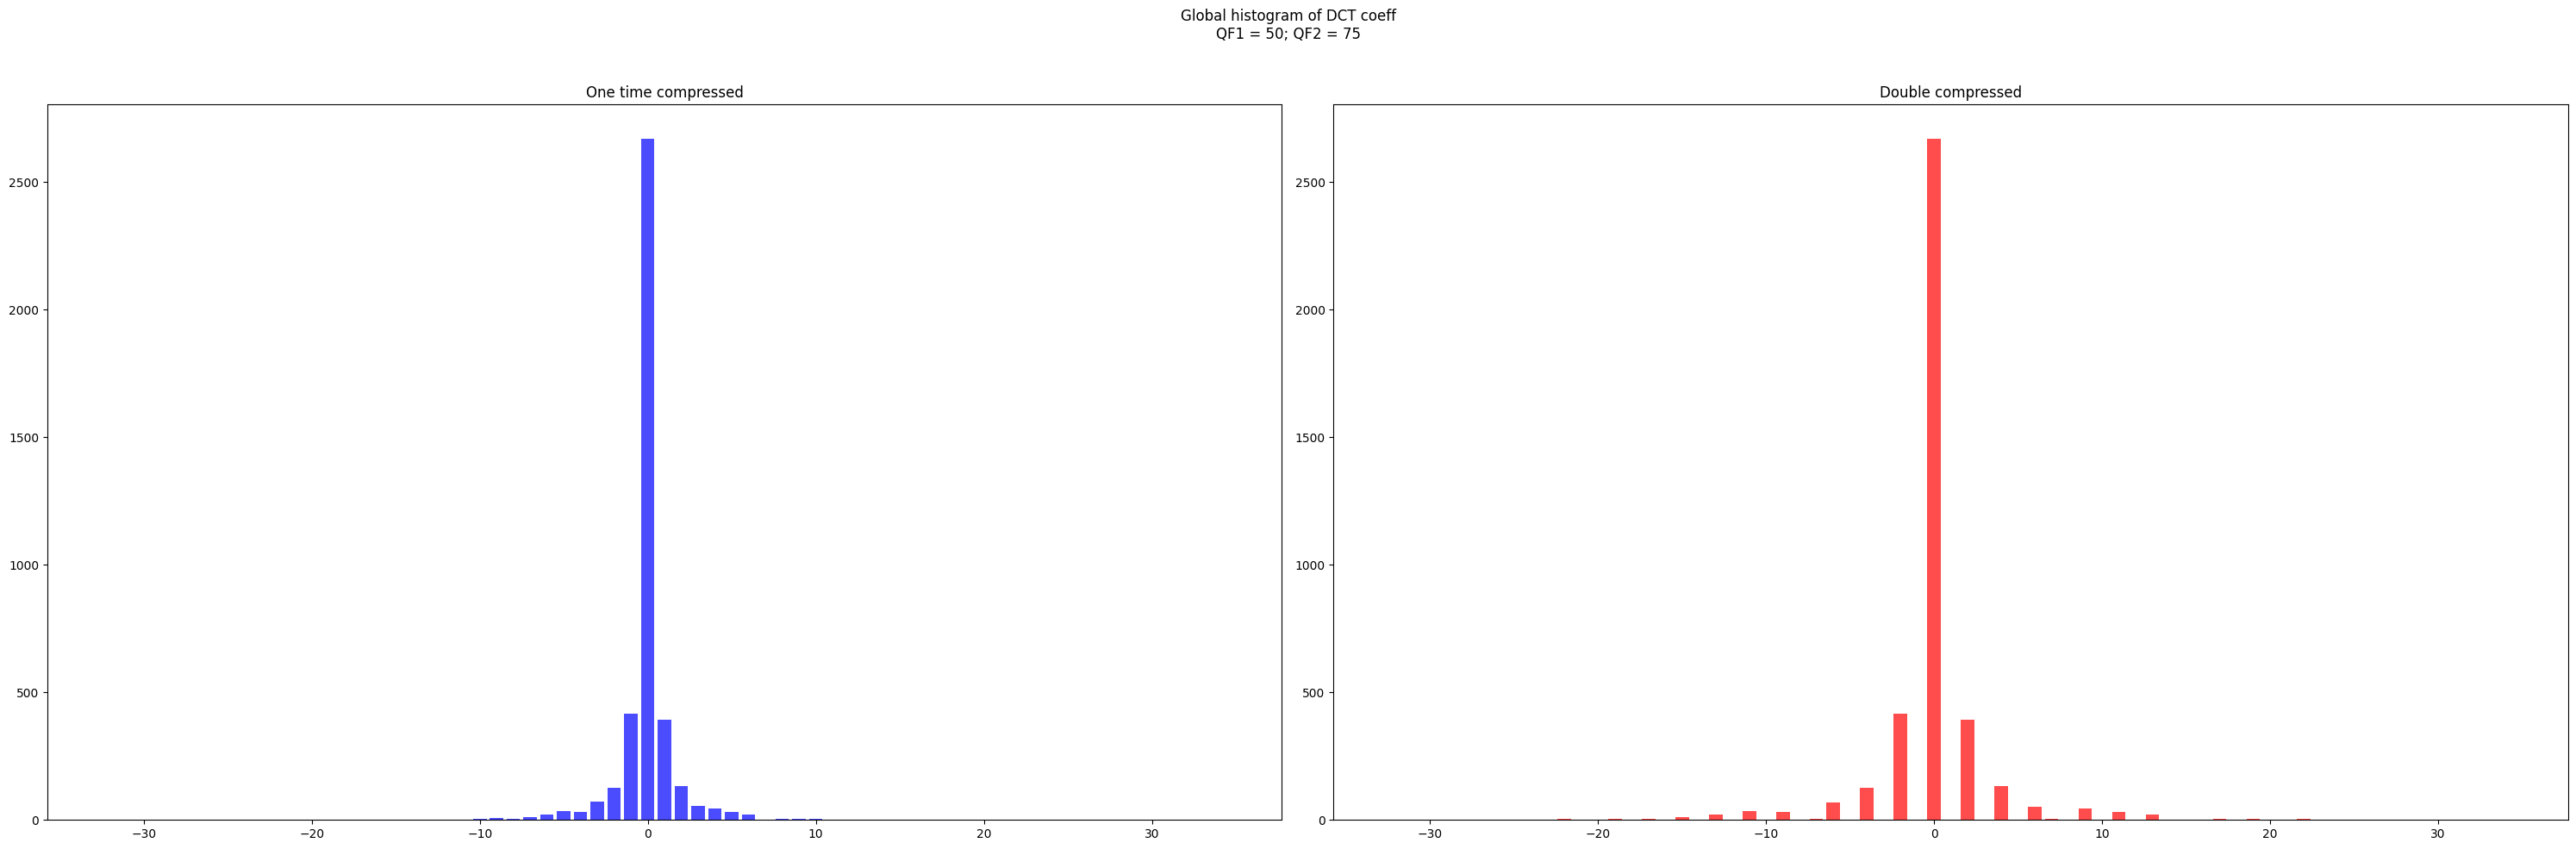

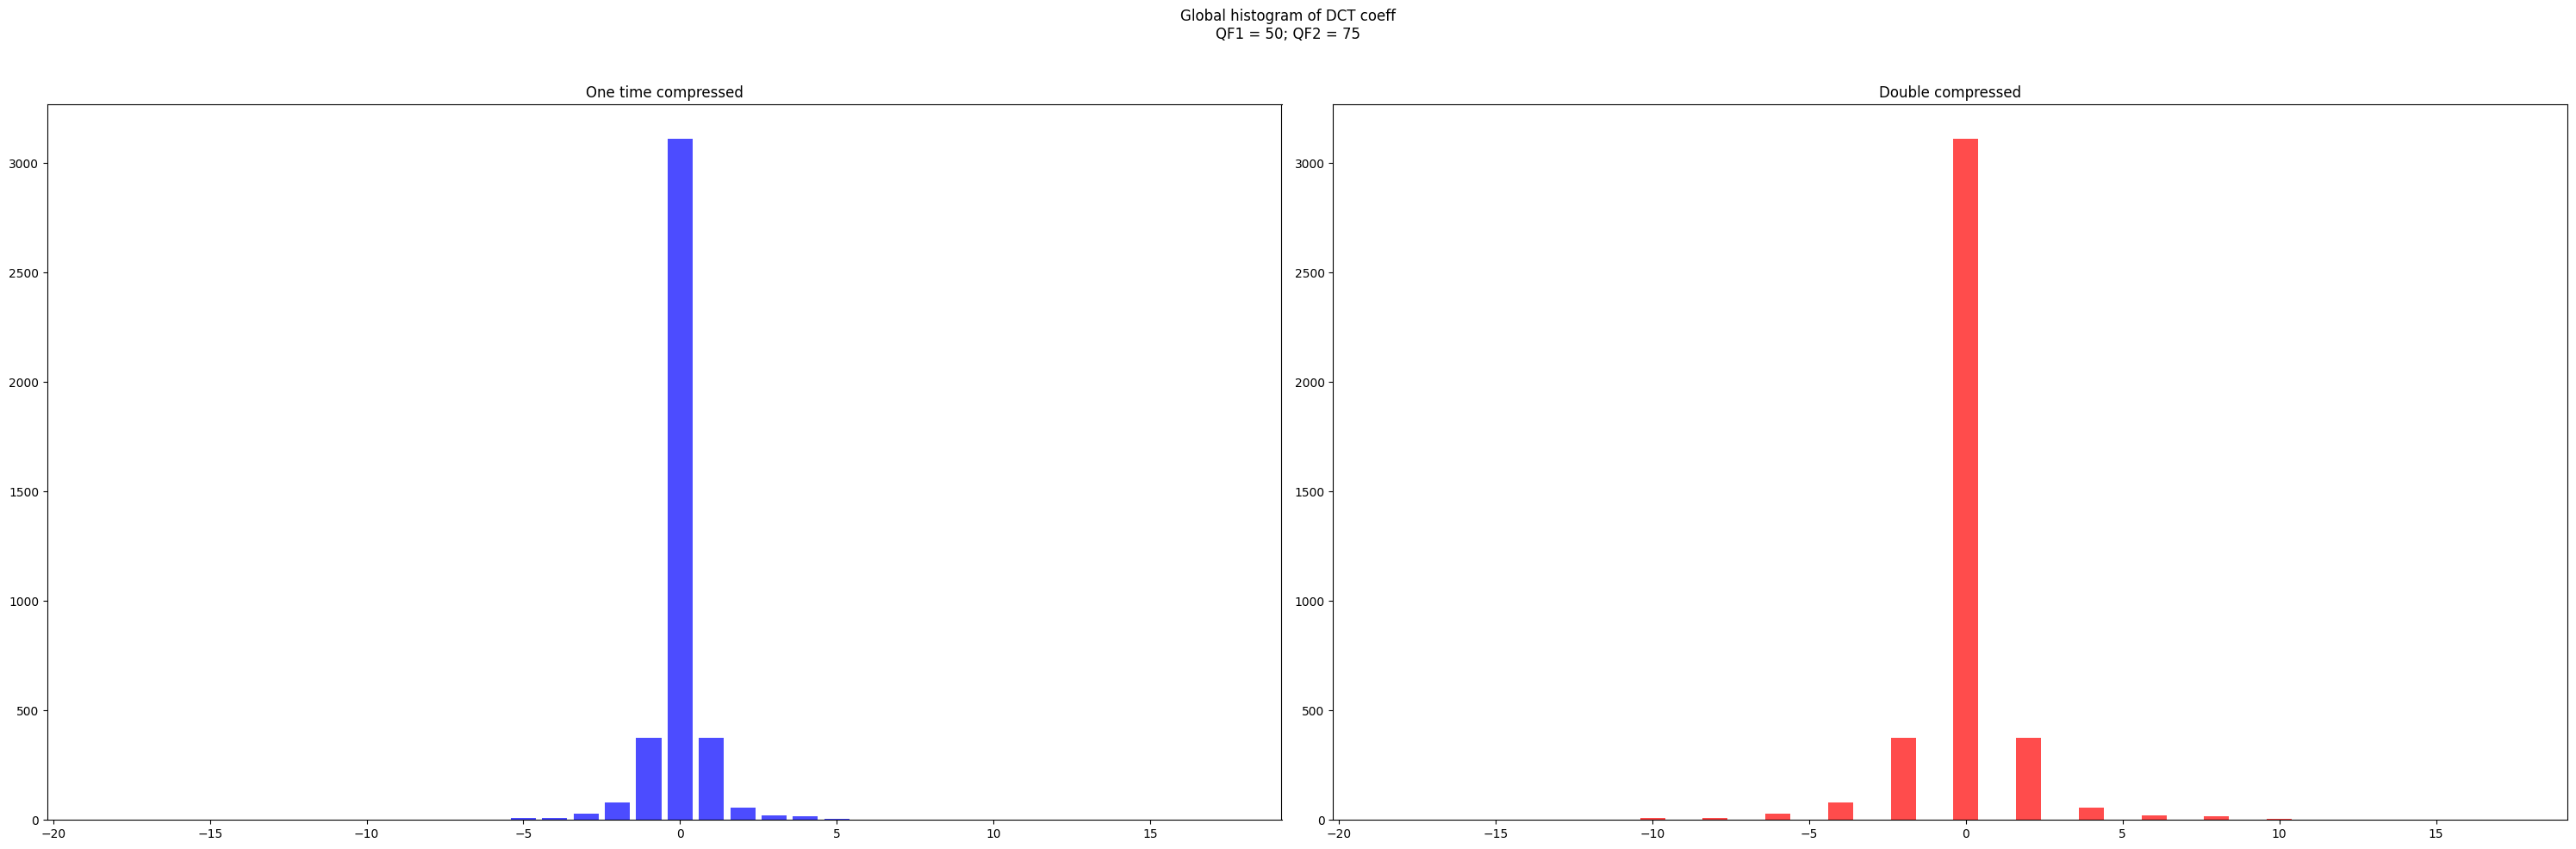

In [63]:
plot_histogram_coefficient_pairwise(dct_quantized_coeff=compressed_image_qf1[2], dct_quantized_coeff2=double_compressed_image_qf2[2])


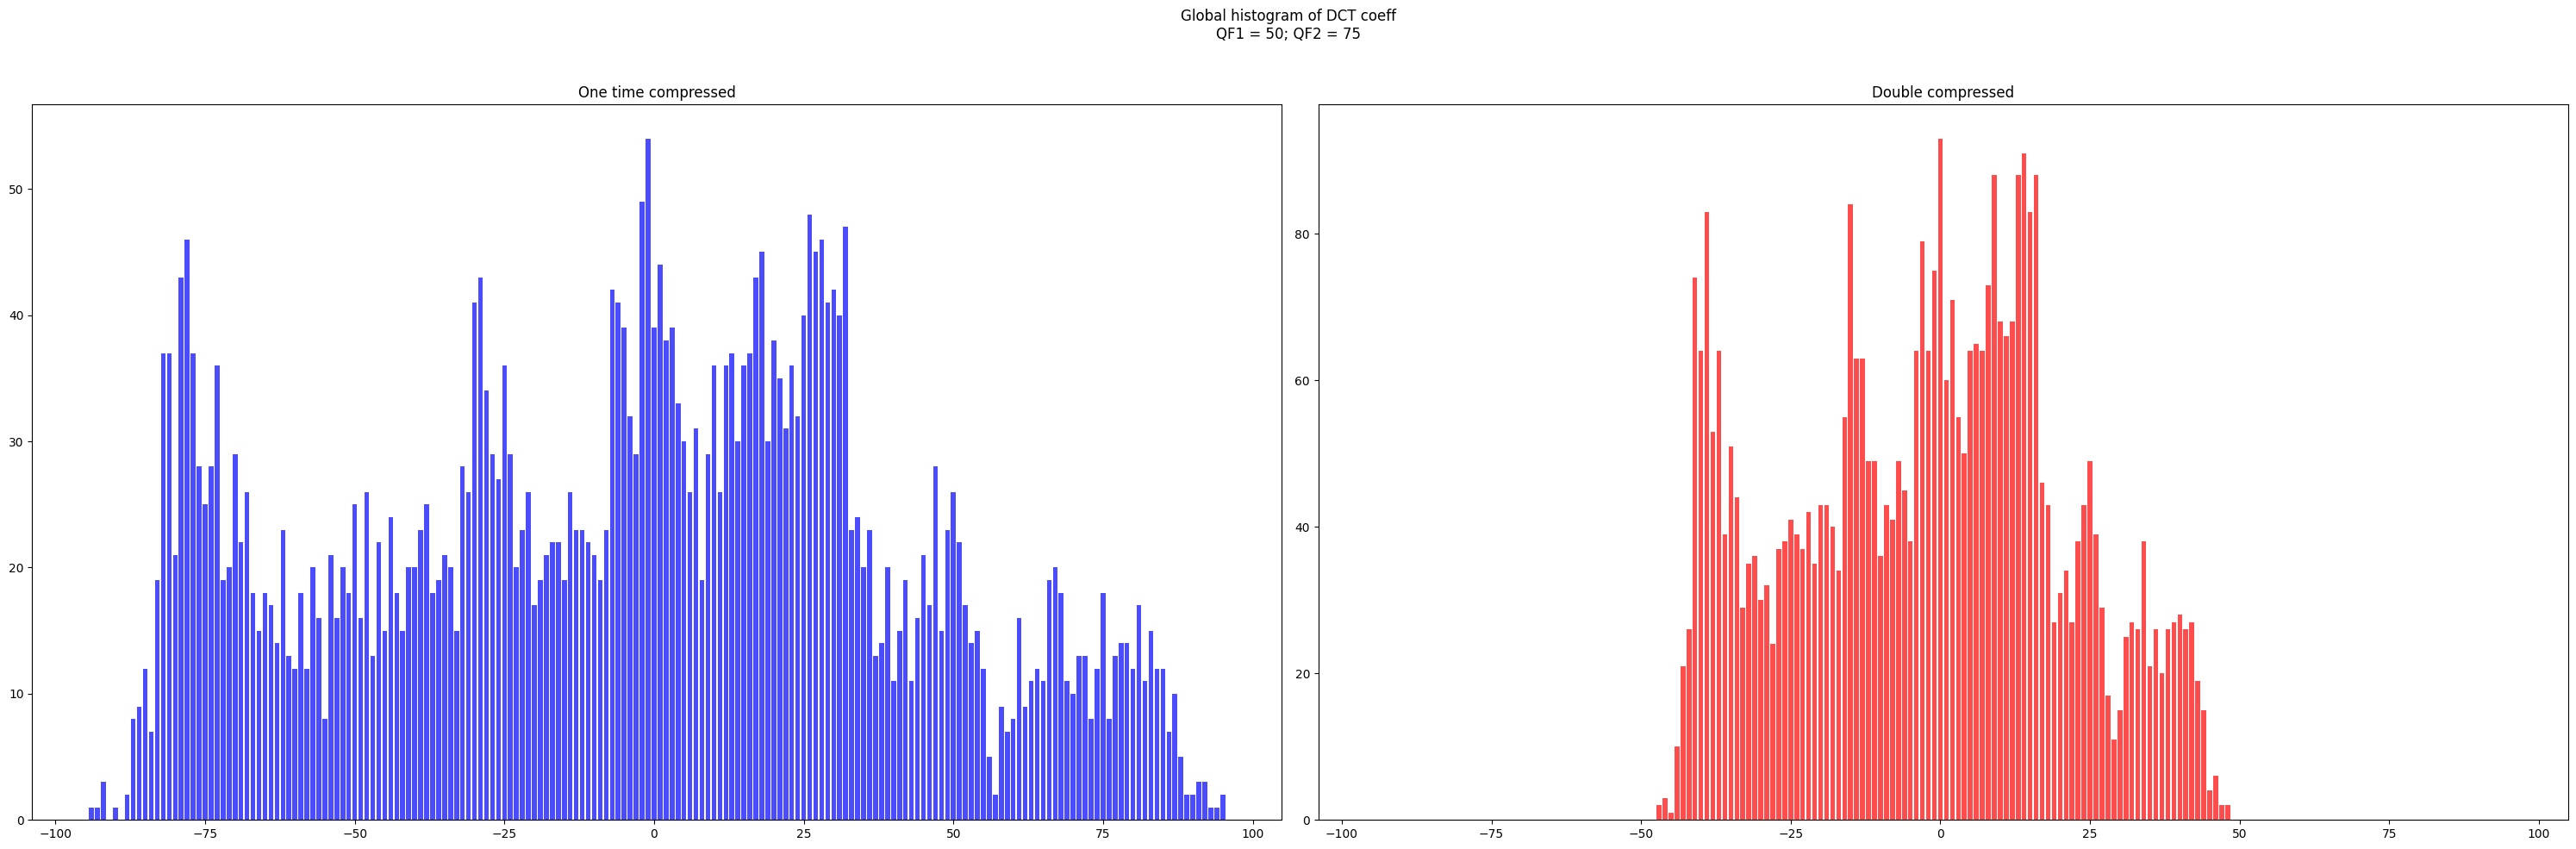

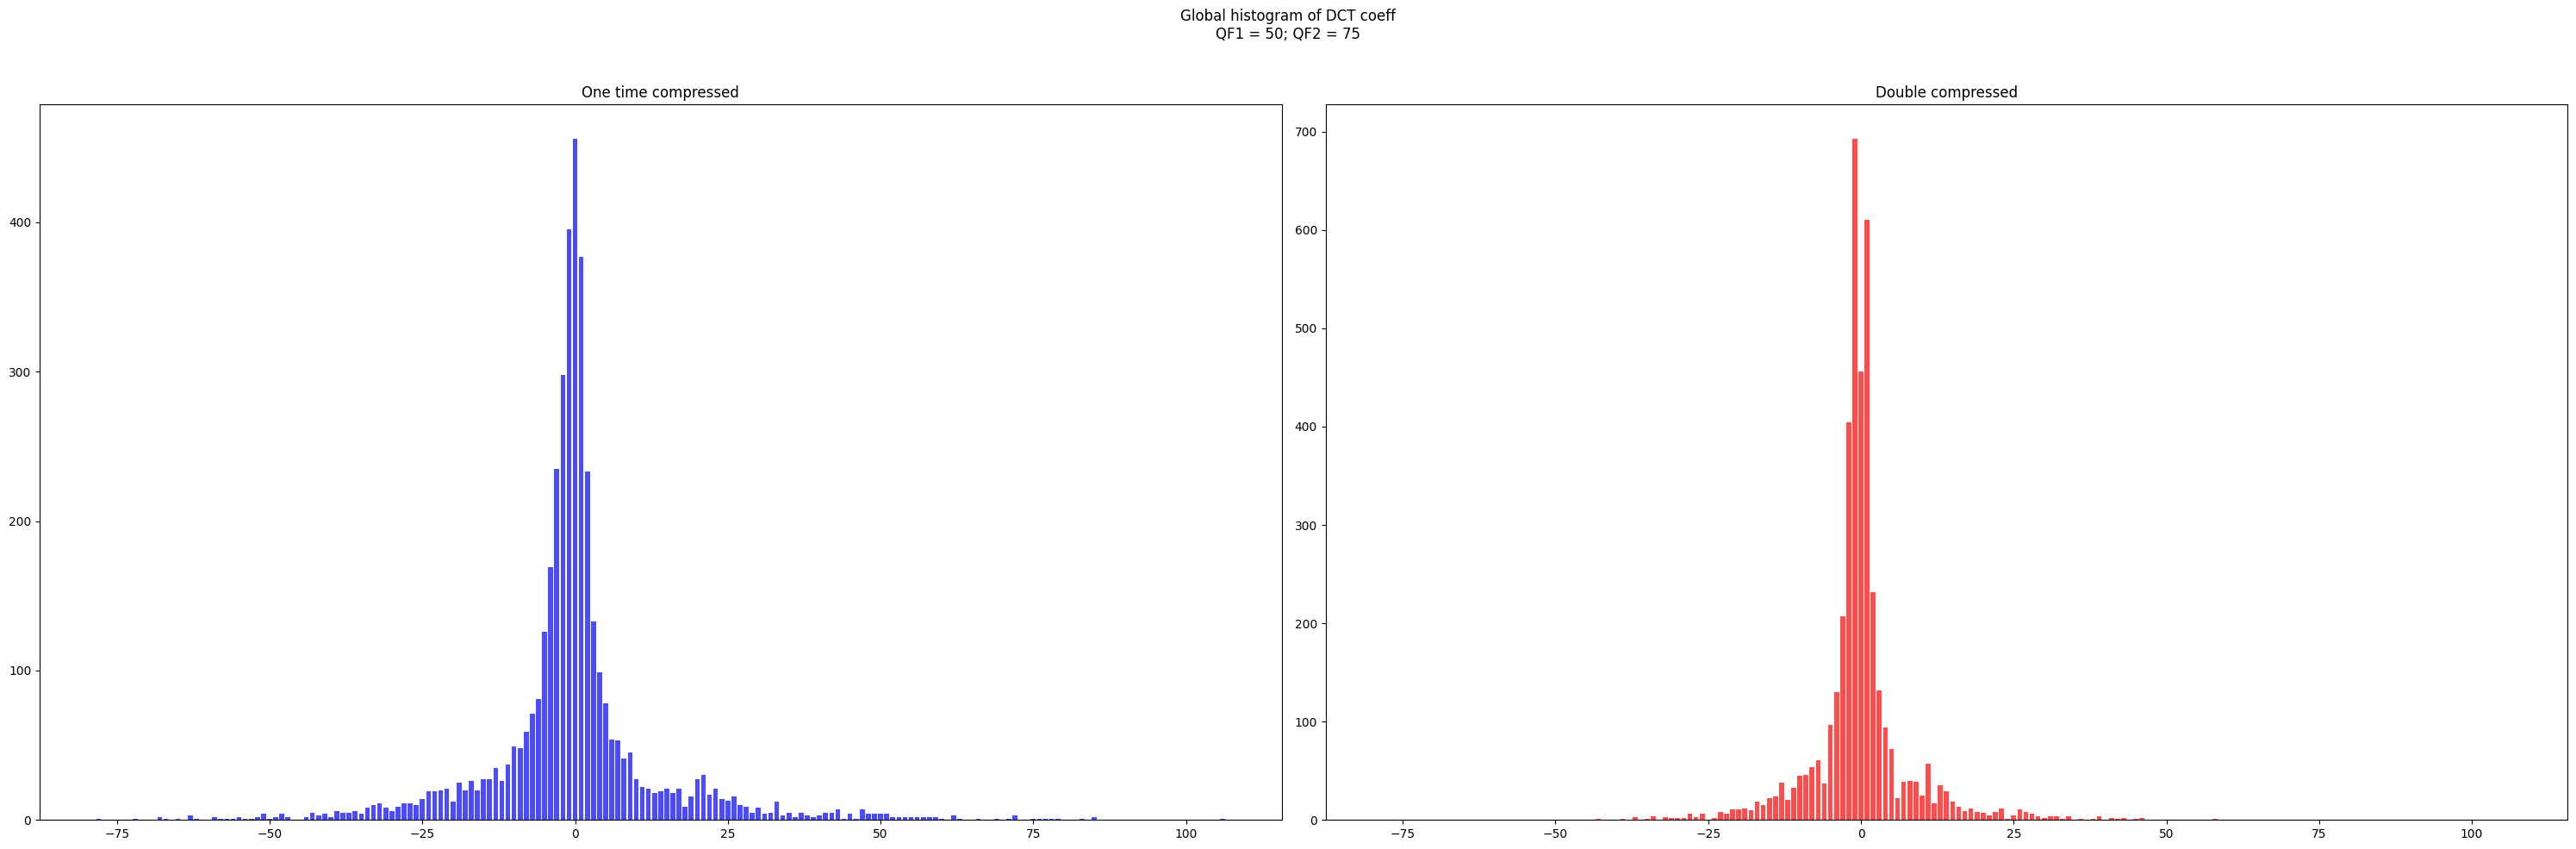

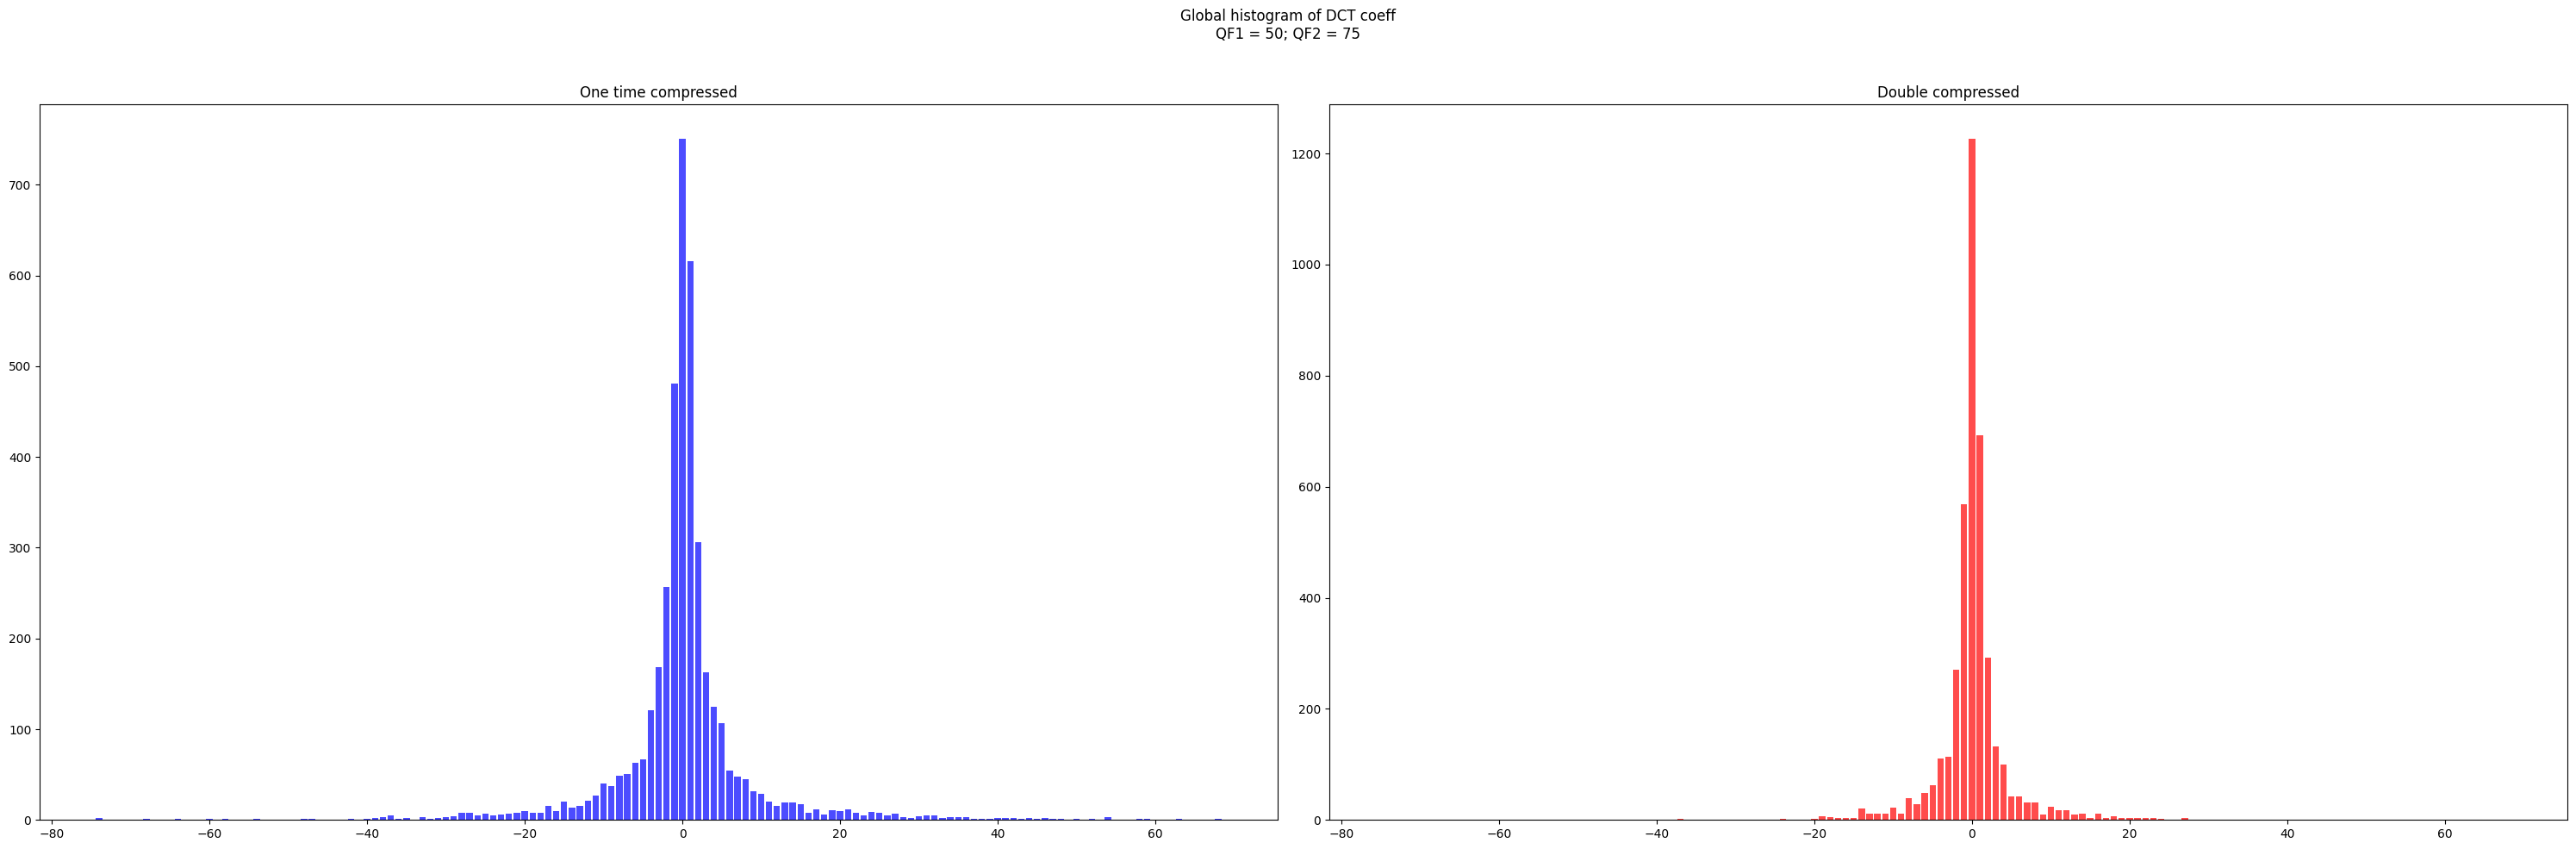

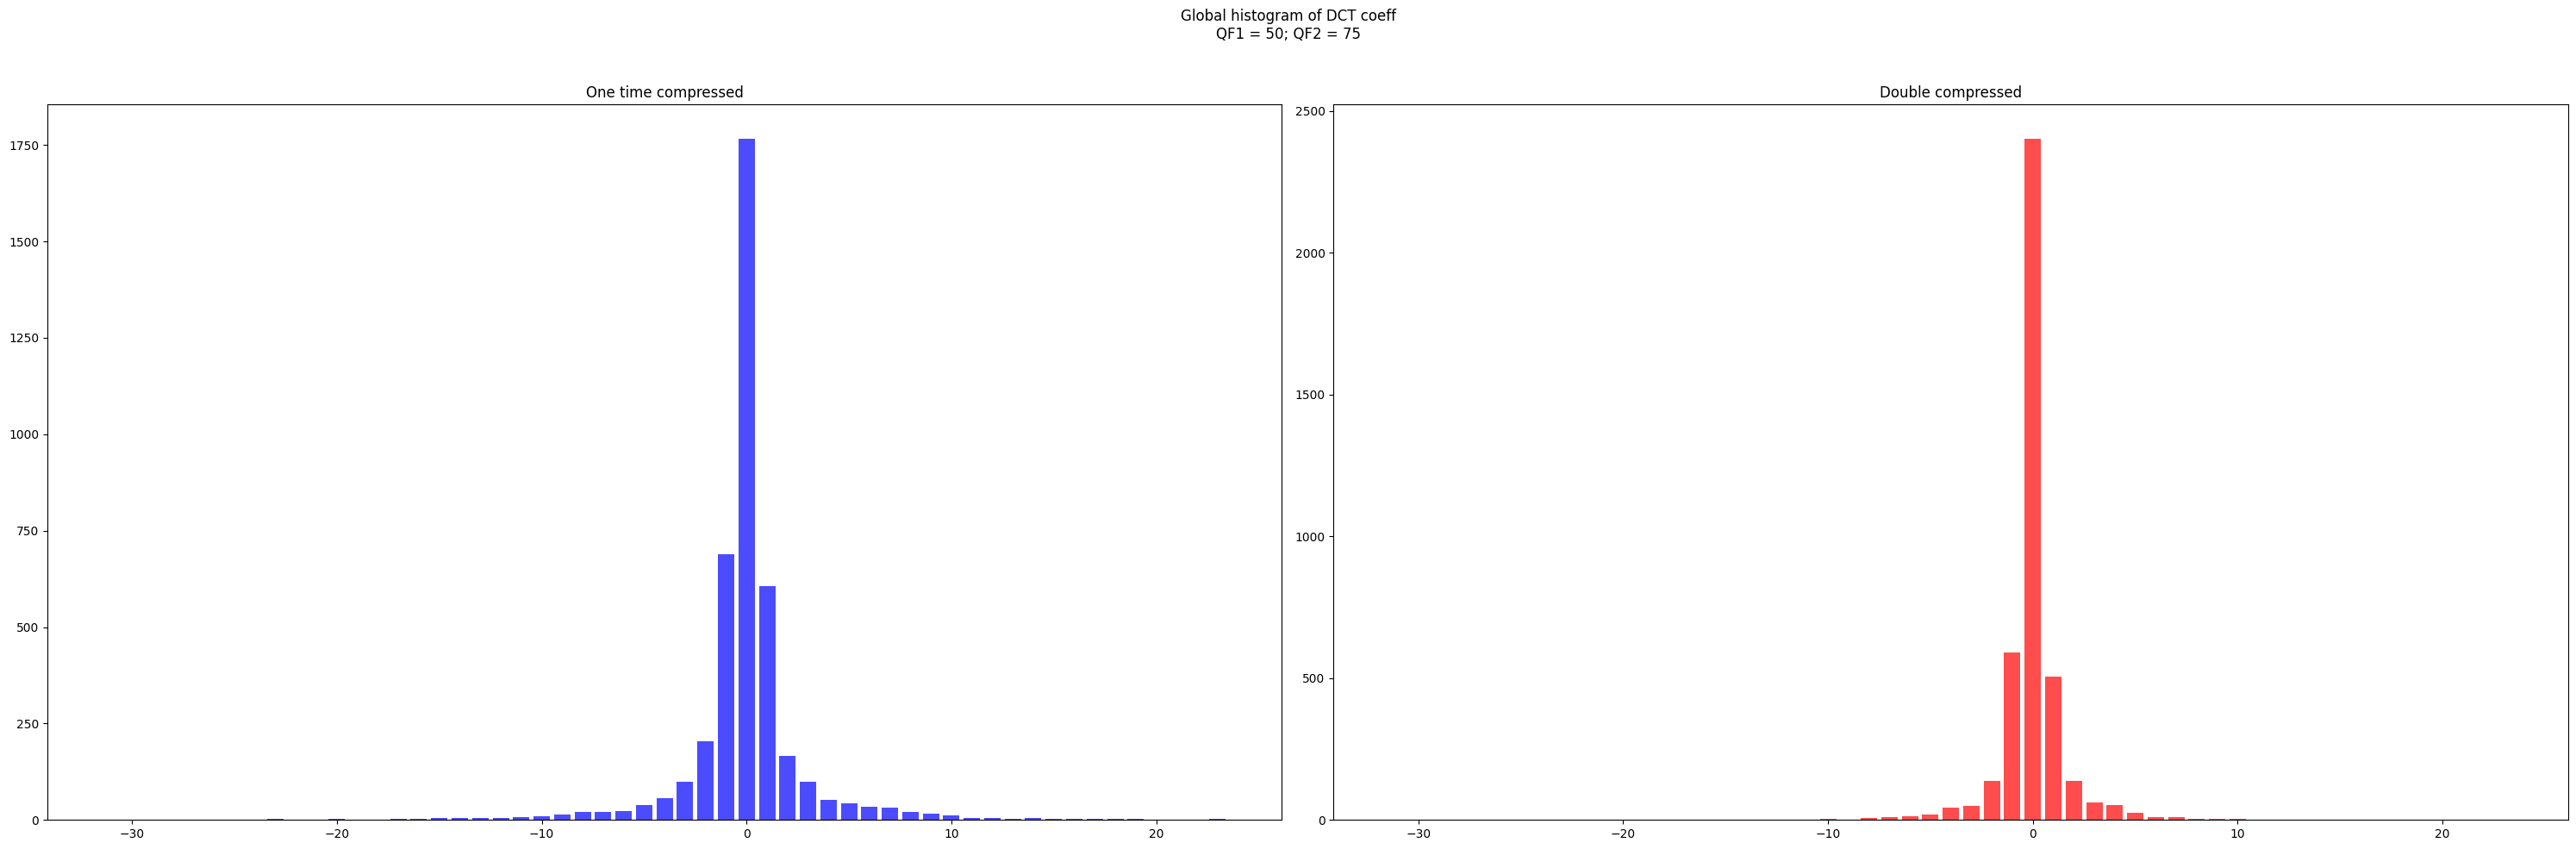

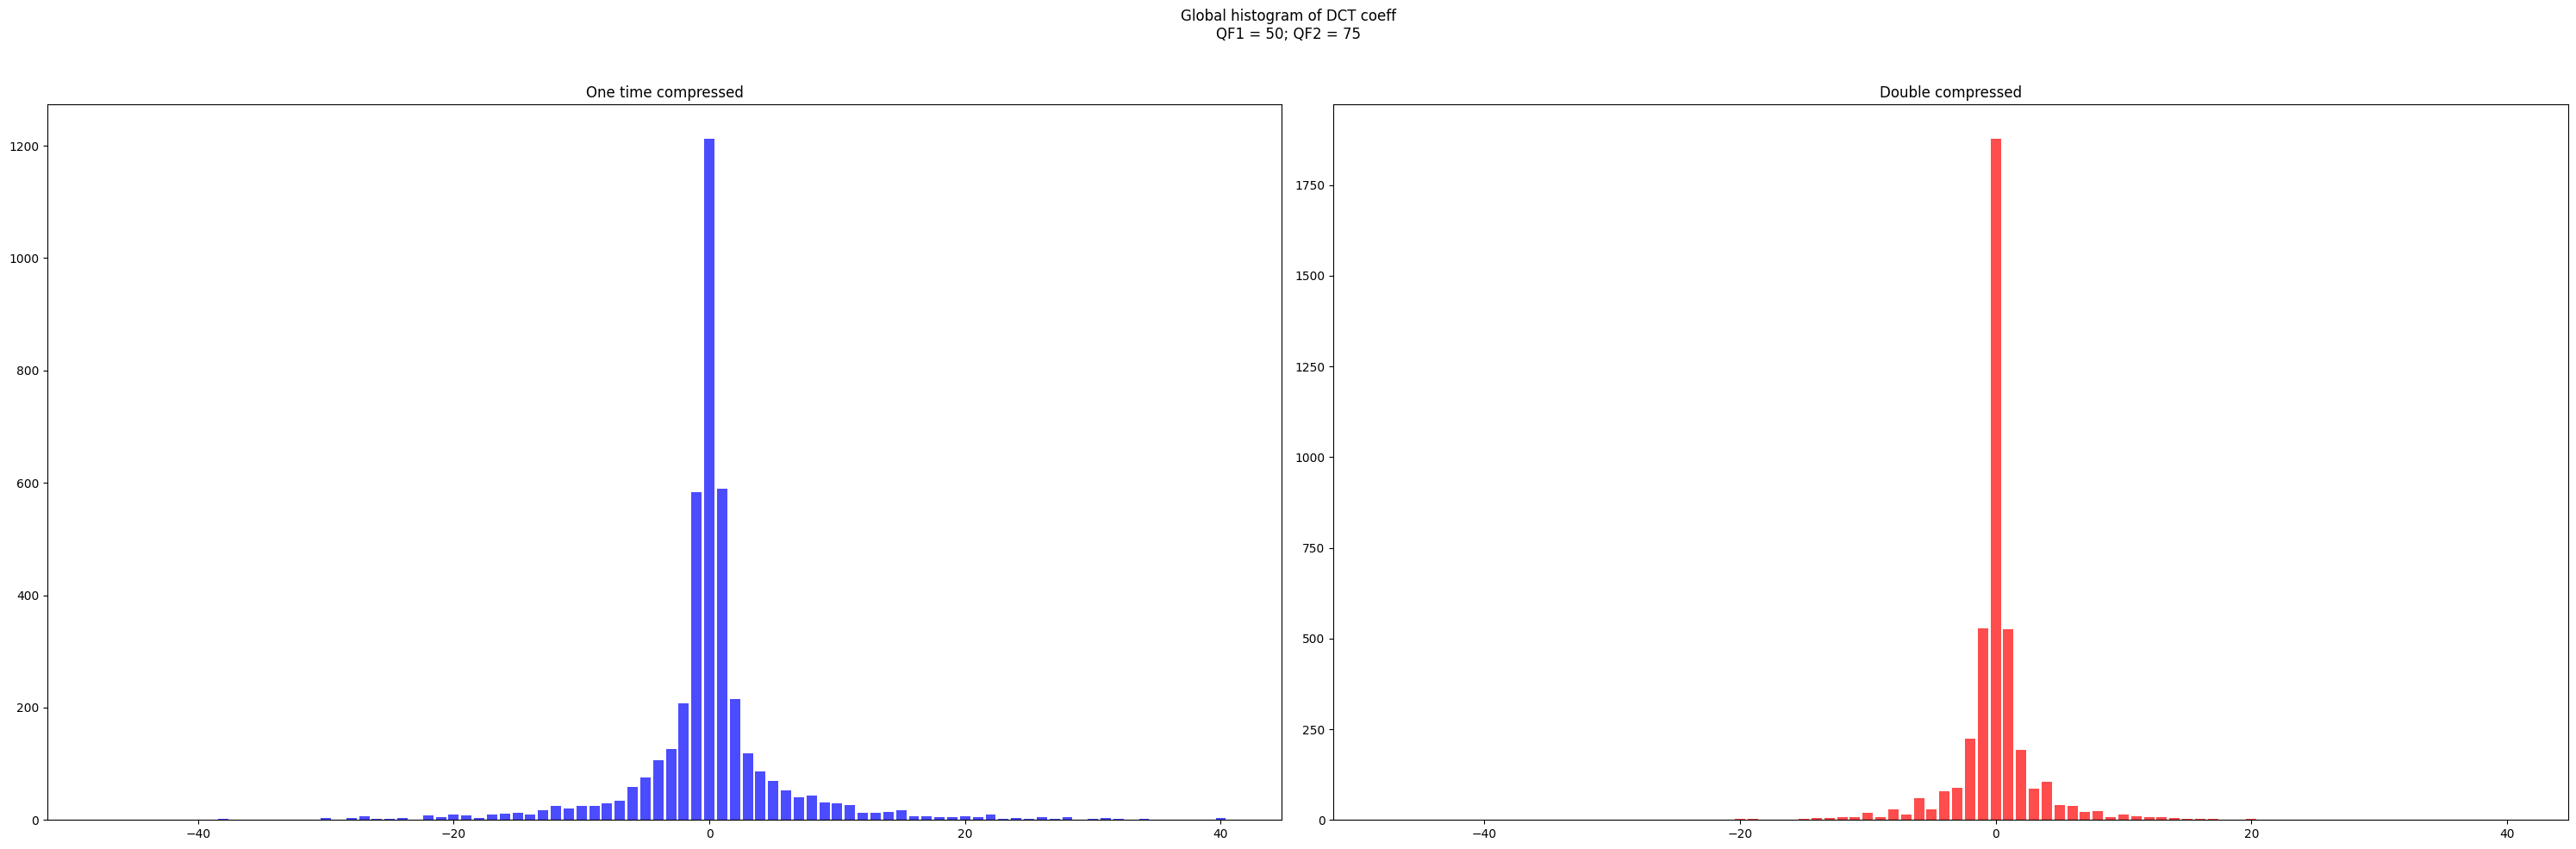

Error in callback <function flush_figures at 0x12a98b100> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [64]:
plot_histogram_coefficient_pairwise(dct_quantized_coeff=compressed_image_qf2[2], dct_quantized_coeff2=double_compressed_image_qf1[2])

For this pairwise histograms we know that after zigzag reordering, the first element contains the most important information about the image, and than the importance of the elements decrease. That's what we observe in the graphics. For example when the first one is set between (-50, 50), the last one is approximatly between (-5,5). The number of elements in the bin is also increasing more we approach the end of the list, because the number of 0 elements is increasing.

In this case we can observe the same patterns of compression as in the previous example. For smaller quality factor we can observe that the data is less distributed and more concentrated near 0. The inverse behaviour is observed for higher QF. 

# Step 3: detection of image manipulation based on double JPEG compression detection

In [65]:
def plot_histogram_step3(dct_quantized_coeff):
    # Create a grid of subplots with 3 columns
    num_plots = 10
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols  # To calculate the number of rows needed

    plt.figure(figsize=(30, 10 * num_rows))  # Adjust figure size based on number of rows

    for i in range(num_plots):
        x_bin = np.arange(dct_quantized_coeff[i, :].min(), dct_quantized_coeff[i, :].max() + 1)

        y_quantized, _ = np.histogram(dct_quantized_coeff[i, :], bins=x_bin)

        # Create subplots in a 3-column layout
        plt.subplot(num_rows, num_cols, i + 1)  # num_rows x num_cols grid, i+1-th plot
        plt.bar(x_bin[:-1], y_quantized, width=0.8, color='b', alpha=0.7)
        plt.title(f'Element {i + 1}')  # Title indicating x-th element

    # Add a super title for the whole figure
    plt.suptitle(f'Pairwise histograms of DCT coeff\nQF1 = {QF1}; QF2 = {QF2}', fontsize=20)

    # Adjust layout so titles and plots fit well
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Display all the plots
    plt.show()

In [33]:
man_image_1_v1 = np.concatenate((compressed_image_qf1[2], double_compressed_image_qf2[2]), axis=1)
man_image_1_v2 = np.concatenate((compressed_image_qf2[2], double_compressed_image_qf1[2]), axis=1)

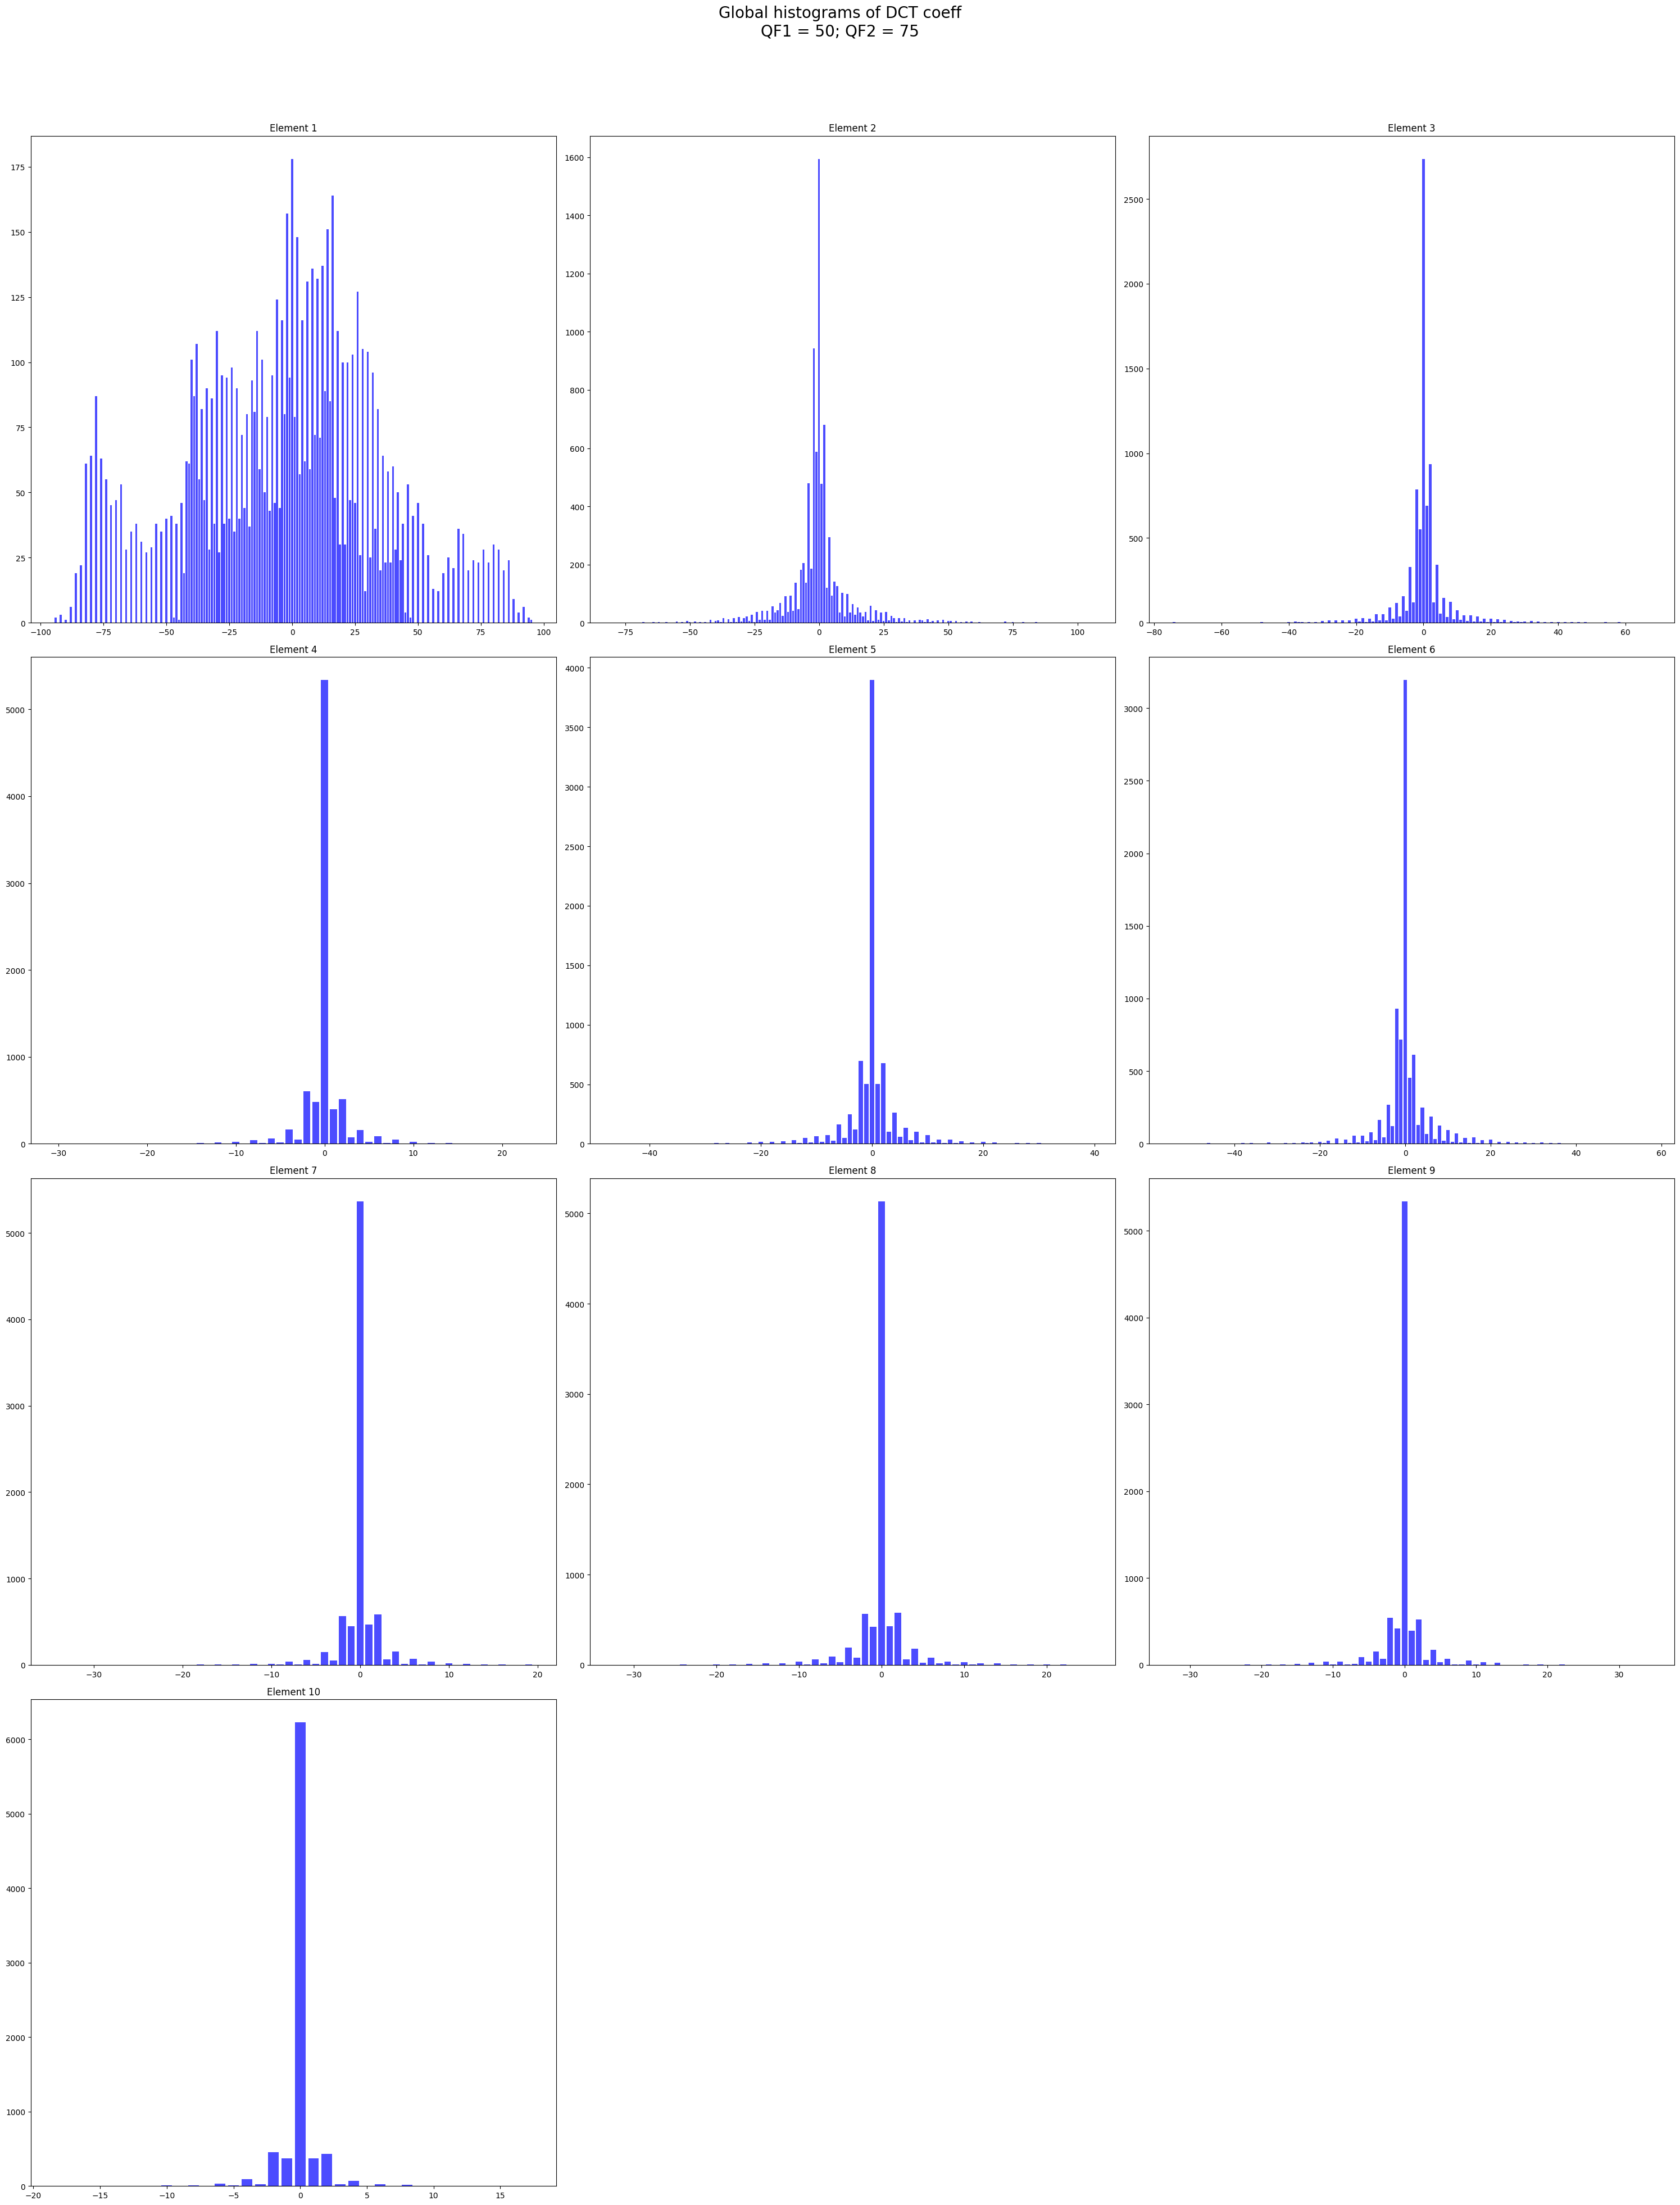

In [34]:
plot_histogram_step3(man_image_1_v1)

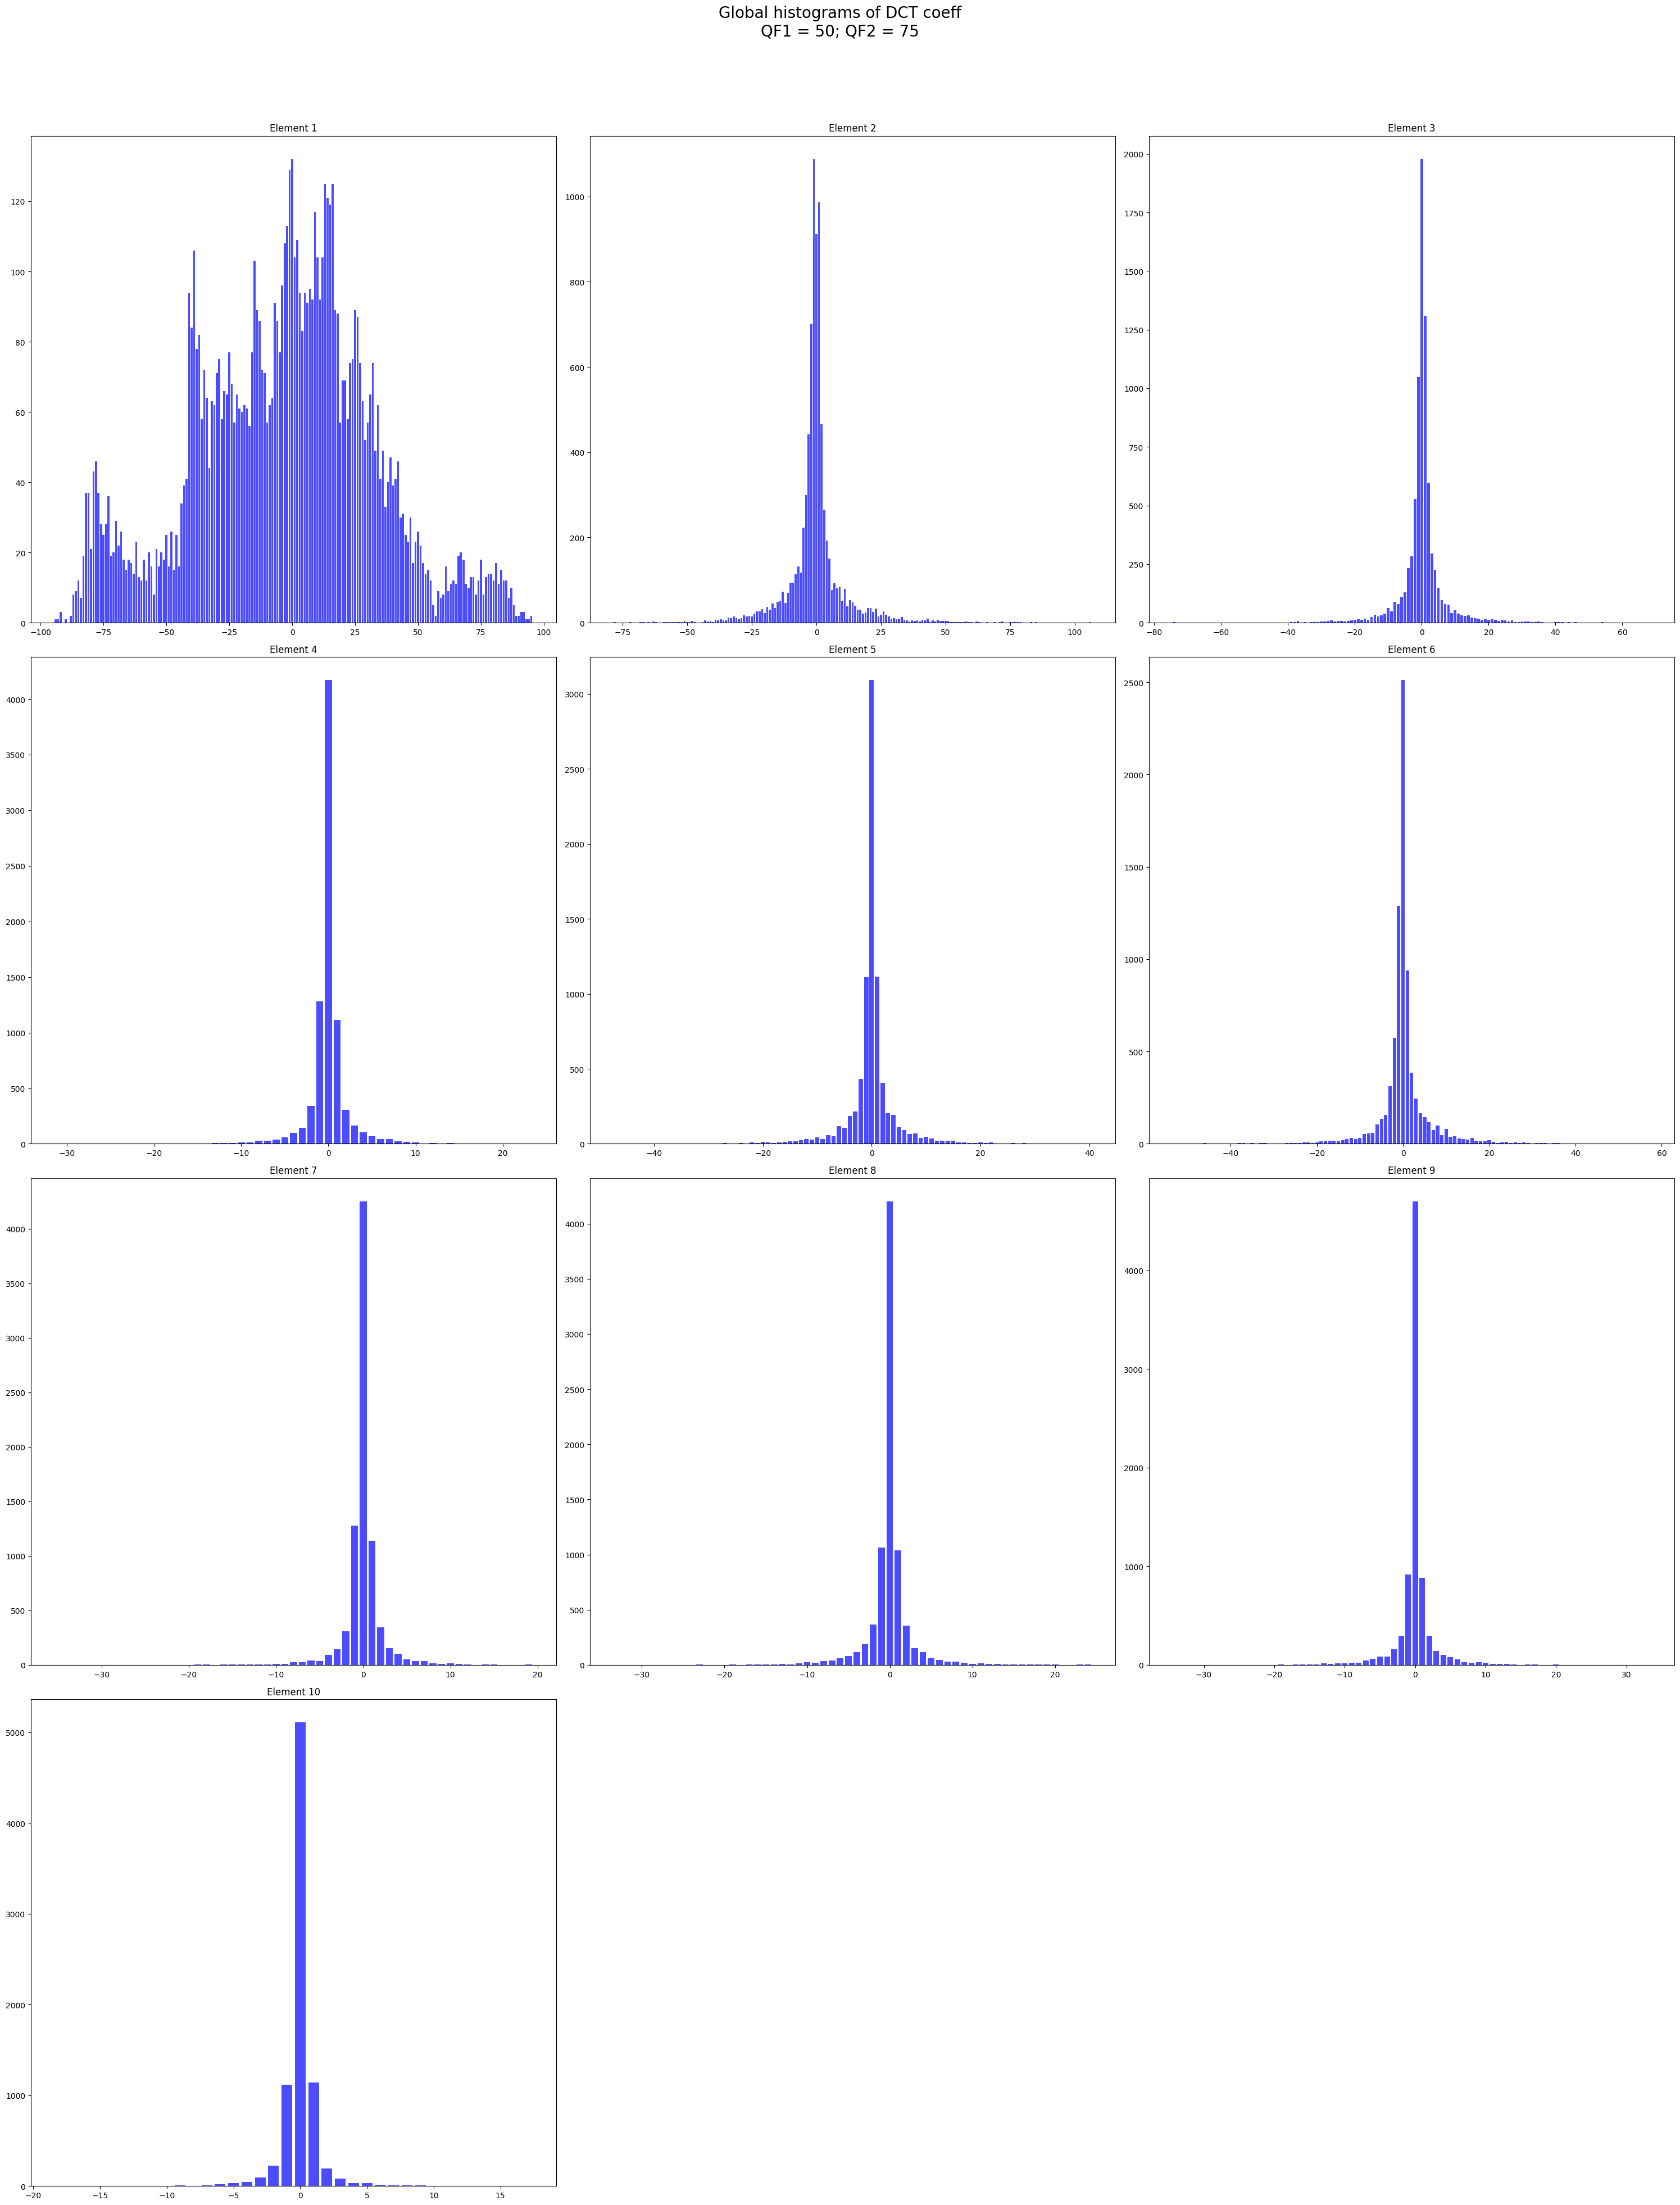

In [35]:
plot_histogram_step3(man_image_1_v2)

In first case (QF1 < QF2) we can observe in first elements that some bins contain more samples. This come from the fact that there are a lot of elements coming from the first aggressive compression. This is the case of double compression. 

In the second case (QF1 > QF2) it's more difficult to notice, because first compression was less aggressive and it created less information loss (so less samples near 0). It is more difficult to notice on this charts. I have the same impression for ManImage1 above and ManImage2 below.

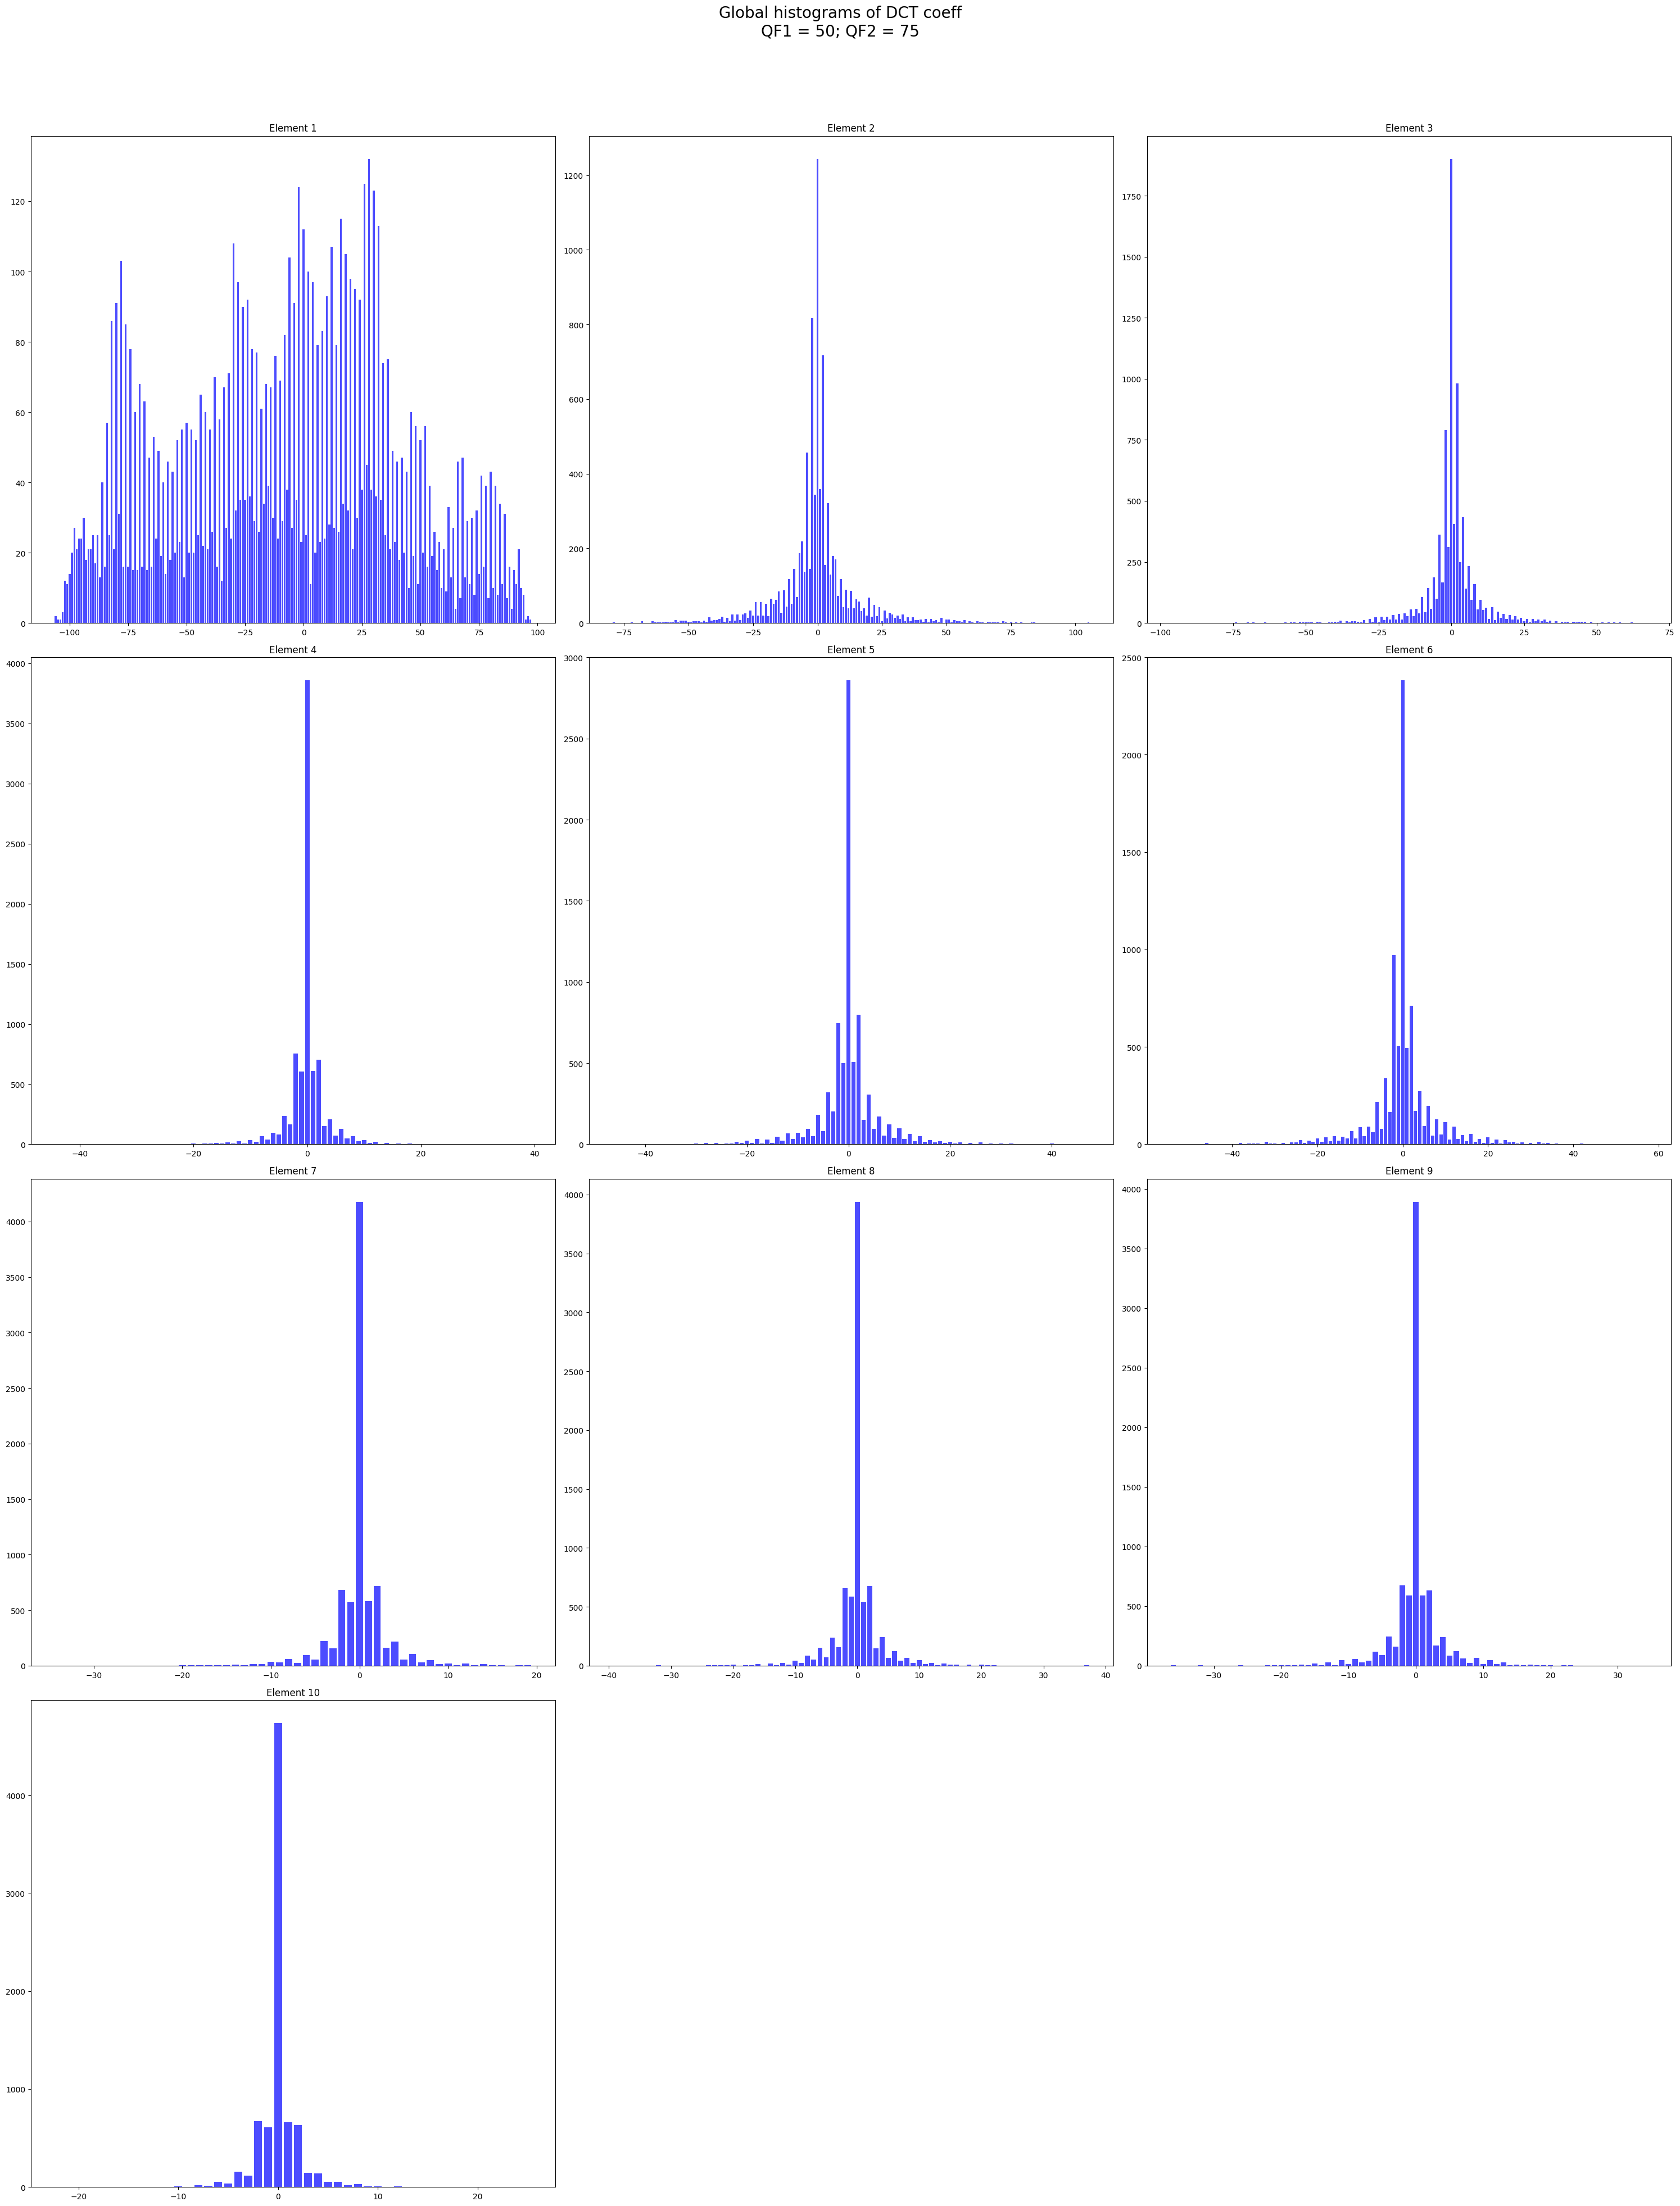

In [36]:
I_orig2 = Image.open('2024_DF_Lab3_Code/barbara512.bmp')

I_orig2 = np.array(I_orig2, dtype=float) # Convert the image to double precision

ManImage2 = np.concatenate((compressed_image_qf1[4], I_orig2), axis=1)

_ , _ , ManImage2_coeff_zigzag , _ , ManImage2_restored = JPEG_compression(ManImage2, QF2)

plot_histogram_step3(ManImage2_coeff_zigzag)

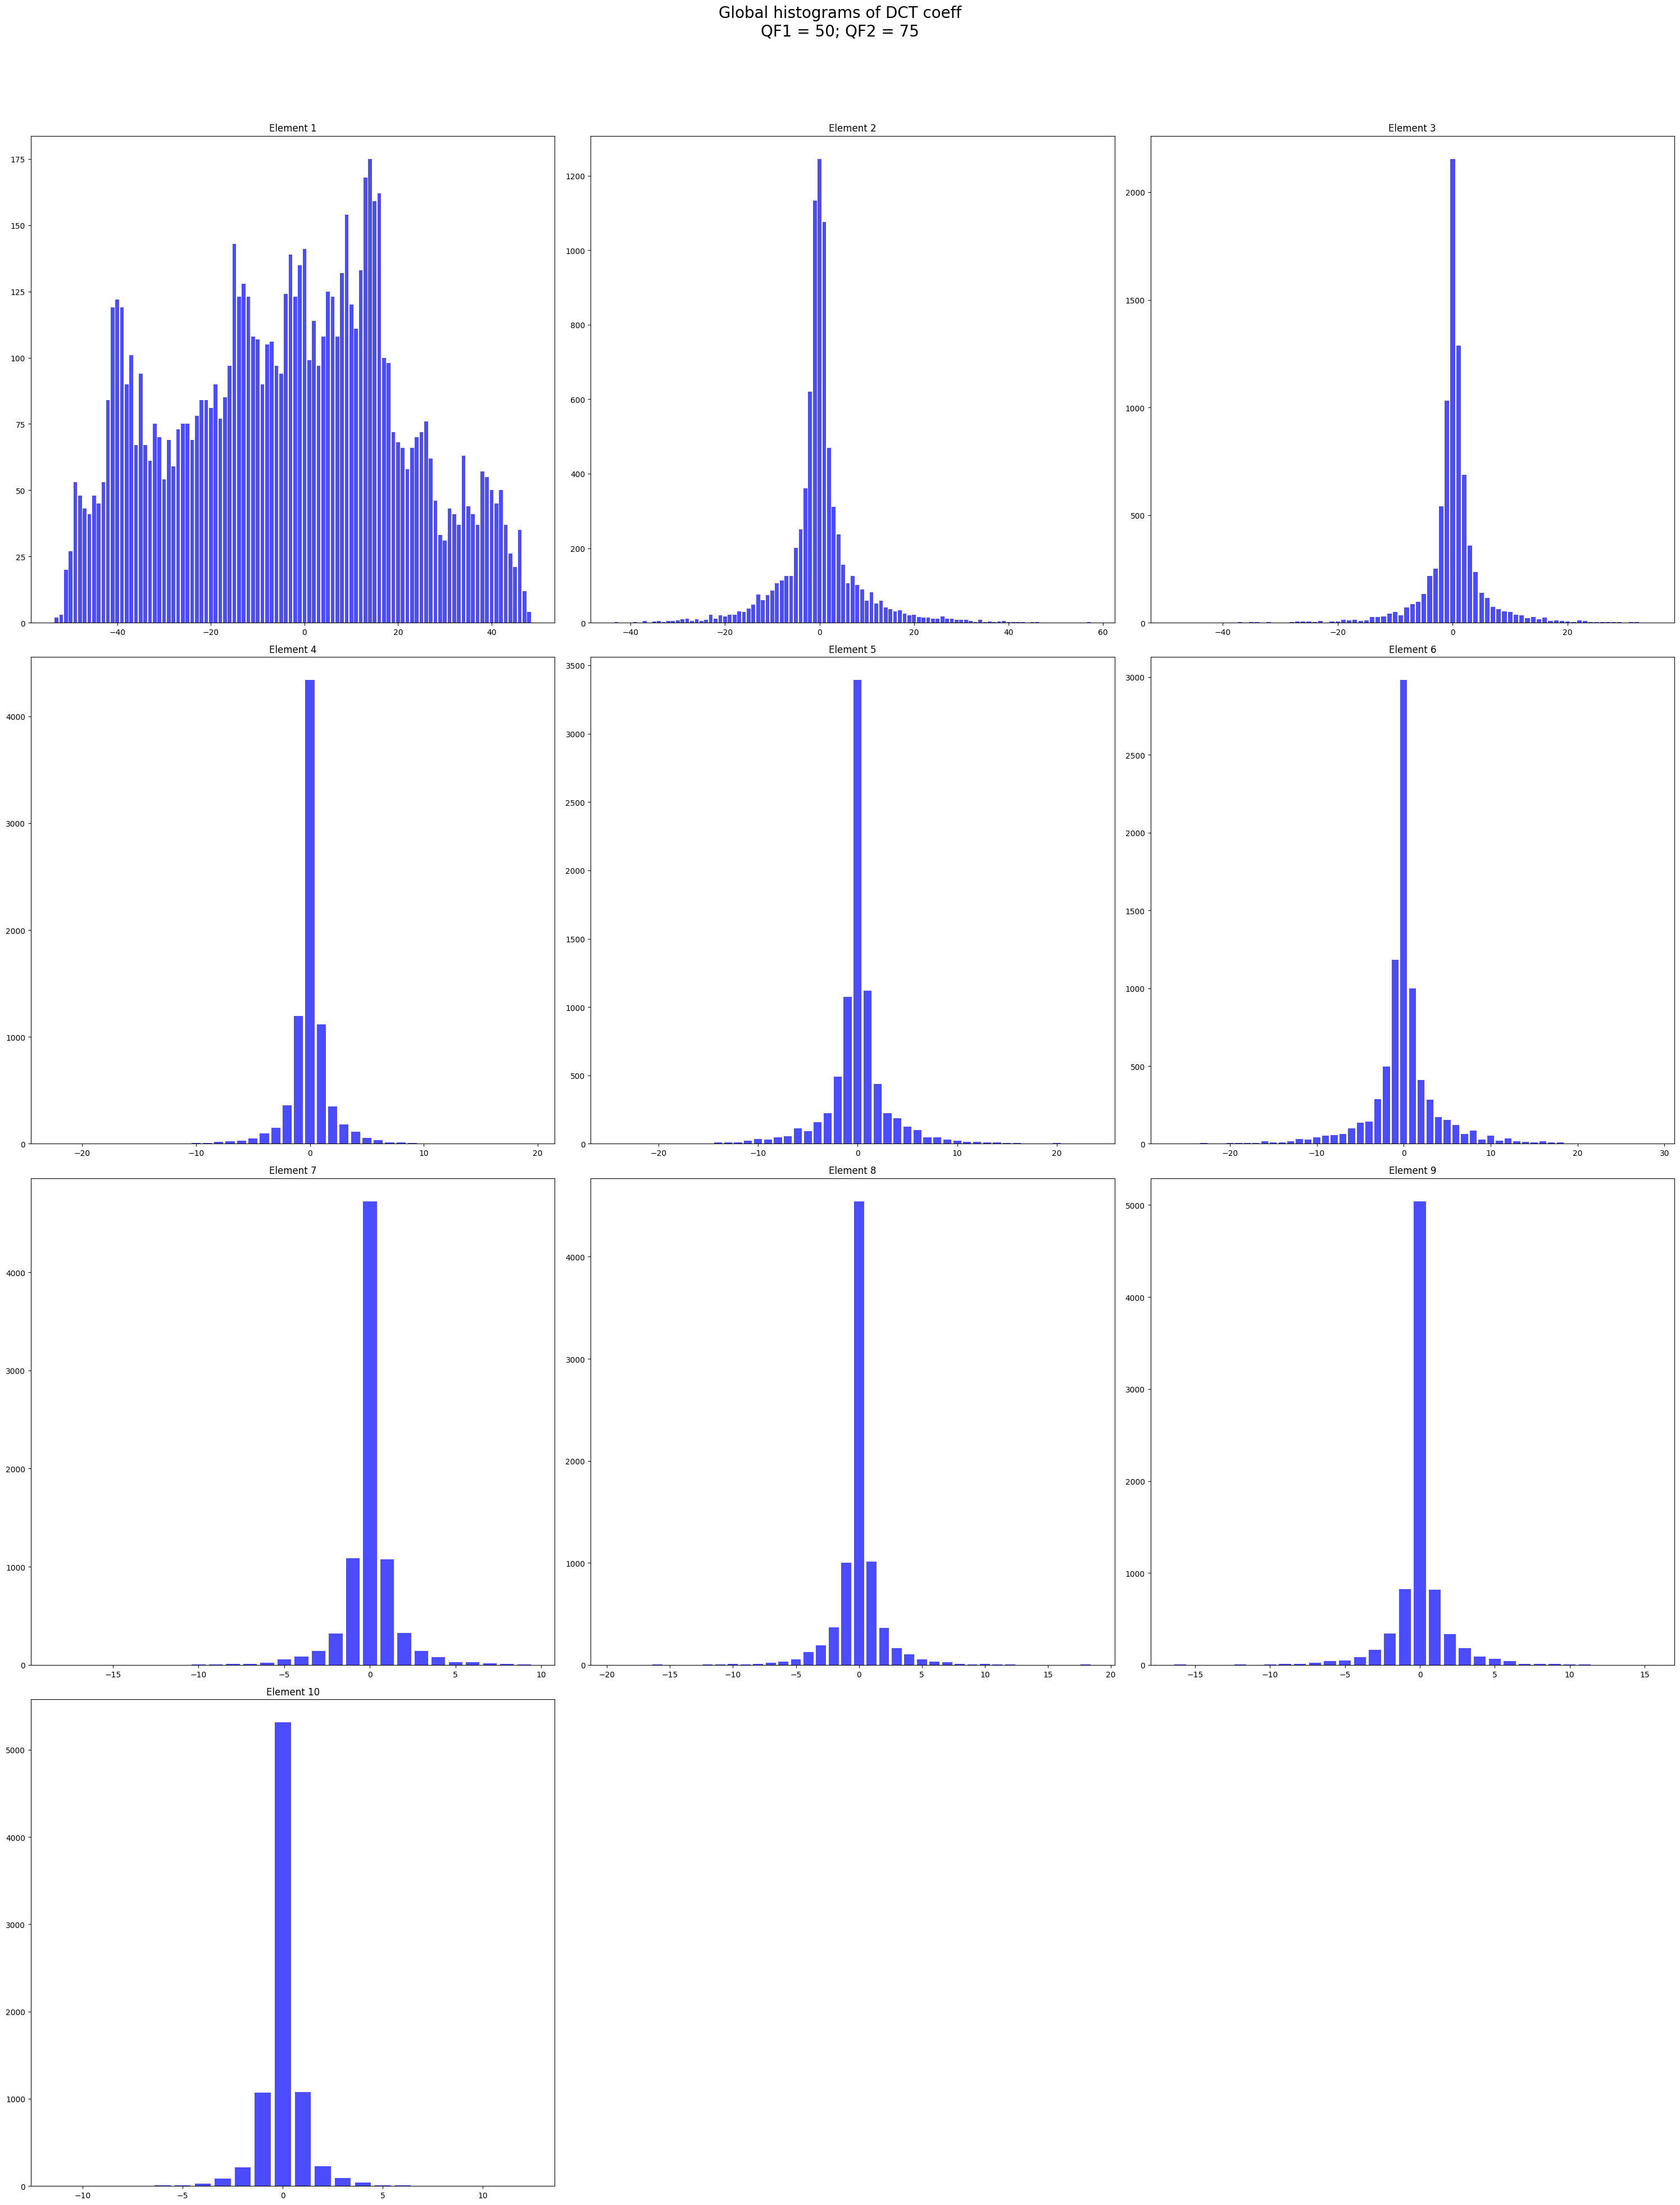

In [37]:
I_orig2 = Image.open('2024_DF_Lab3_Code/barbara512.bmp')

I_orig2 = np.array(I_orig2, dtype=float) # Convert the image to double precision

ManImage2 = np.concatenate((compressed_image_qf2[4], I_orig2), axis=1)

_ , _ , ManImage2_coeff_zigzag , _ , ManImage2_restored = JPEG_compression(ManImage2, QF1)

plot_histogram_step3(ManImage2_coeff_zigzag)

ManImage1 (QF2 > QF1 and QF2 < QF1):
In the case of ManImage1, we concatenate the DCT quantized coefficients of an image that had two compressions.

For QF2 > QF1 the double compression effect is noticeable. We can observe on the chart that some bins contain more samples. This is due to double quantization that was done during the double compression. For QF2 < QF1 the detection is difficult because the second compression, using a higher QF value, retains more of the original DCT coefficients, making the histogram appear closer to that of a singly compressed image.

ManImage2 (QF1 > QF2 and QF1 < QF2) :
For ManImage2, the process involves concatenating a compressed image with another image, and then compressing this concatenated image using QF2.

For QF1 > QF2 similar to ManImage2 the effect of double compression is noticeable. For QF1 < QF2 the detection becomes more challenging. To find the artifacts introduced by double compression would require more sophisticated methods for detection.


We can clearly observe the manipulation when the first image was heavily compressed, followed by less agressive compression. Inverse case is more difficult to notice based on historgam analysis.